## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Vizualizations and Statistical analysis 


### Package imports 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from numpy import median
import math
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from itertools import chain
import warnings
from bioinfokit.analys import stat
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bioinfokit import visuz
warnings.filterwarnings("ignore")
import copy

In [2]:
path = 'C:\\Users\\purpl\\Box\\GAIT\\sample_data\\data_export\\'

In [3]:
#Reading the raw dataframe 
raw_df = pd.read_csv(path+'..\\..\\gait_features.csv', index_col = 0)
#Dropping the NaNs
raw_df.dropna(inplace = True)
#Resetting the index
raw_df.reset_index(inplace= True)
print ('Raw data shape: ', raw_df.shape)

#Reading the Size-N dataframe 
sizeN_df = pd.read_csv(path+'..\\..\\size_normalized_gait_features.csv', index_col = 0)
#Dropping the NaNs
sizeN_df.dropna(inplace = True)
#Resetting the index
sizeN_df.reset_index(inplace= True)
print ('Size-N data shape: ', sizeN_df.shape)

#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\csv files\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Reading the demographics of the subjects
demographies = pd.read_csv(path + '..\\demographics.csv')

#Keeping demographics of only the 35 subjects we have the raw data for 
demographies = demographies[demographies['subject ID'].isin(raw_df['PID'].unique())]

Raw data shape:  (3230, 34)
Size-N data shape:  (3230, 34)
Regress-N data shape:  (3230, 25)


In [113]:
regressN_df.head()

,index,stride_time,swing_time,stance_time,SS_R,DS_L,DS_R,stride_length,stride_width,cadence,...,force_HSL,force_TOL,force_MidSSL,LeftFPA,RightFPA,Butterfly_x_abs,ButterflySQ_x,PID,TrialID,Label
0,1,1.484333,1.121805,1.626875,1.189094,2.039117,2.094537,0.524177,1.605389,0.666595,...,0.833841,0.942396,1.066435,1.298406,4.360225,5.516202,13.720482,200,1,0
1,2,1.508810,1.611607,1.424794,0.948133,1.429381,2.380620,0.416816,1.632826,0.655782,...,0.785786,0.954028,1.008503,-0.765453,-12.345805,2.509670,4.157315,200,1,0
2,3,1.351460,1.121805,1.432468,1.162903,1.669277,1.747150,0.565319,1.710305,0.732134,...,0.799698,0.924948,1.017746,1.913565,15.153691,4.731046,9.873948,200,1,0
3,4,1.573498,1.564206,1.542461,1.545299,1.459368,1.655195,0.525407,1.453448,0.628822,...,0.875031,0.910721,1.093252,-24.329473,16.180574,1.962483,2.713923,200,1,0
4,5,1.323487,1.074404,1.414563,1.058137,1.549329,2.002582,0.549767,2.009793,0.747608,...,0.772972,0.925039,1.051615,37.322527,-22.825616,1.119339,0.311205,200,1,0


In [5]:
print (raw_df[raw_df['TrialID']==1][raw_df['Label']==0].shape)
print (raw_df[raw_df['TrialID']==1][raw_df['Label']==1].shape)
print (raw_df[raw_df['TrialID']==2][raw_df['Label']==0].shape)
print (raw_df[raw_df['TrialID']==2][raw_df['Label']==1].shape)

print (raw_df[raw_df['TrialID']==1].shape)
print (raw_df[raw_df['TrialID']==2].shape)

(905, 34)
(749, 34)
(878, 34)
(698, 34)
(1654, 34)
(1576, 34)


### Data formatting for vizualizing all features on the same plot

In [6]:
#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L']
raw_df.drop(to_drop, axis = 1, inplace= True)
sizeN_df.drop(to_drop, axis = 1, inplace= True)
# regressN_df.drop(to_drop, axis = 1, inplace= True) #Already dropped in regression file

#Normalize all features and dataframes between 0 and 1 to plot on same plot
#All features we need to vizualize 
#Only angles can be negative, rest all features are +ve only 
#So we normalize all features which are +ve between 0 and 1 and then plot on same graph 
#Also, angles we have vizualized already, so can skip those 
#Hence we have 21 total features but we do not vizualize angles and Butterfly features 
features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'stride_length', 'stride_width',
       'cadence', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL']

features_21 = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'cadence', 'stride_length', 'stride_width',
       'LeftFPA', 'RightFPA', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL','Butterfly_x_abs', 'ButterflySQ_x']
#Min-Max normalization 
raw_df_normal = (raw_df[features]- raw_df[features].min(axis = 0))/(raw_df[features].max(axis = 0) - raw_df[features].min(axis = 0))
raw_df_normal_21 = (raw_df[features_21]- raw_df[features_21].min(axis = 0))/(raw_df[features_21].max(axis = 0) - raw_df[features_21].min(axis = 0))
sizeN_df_normal = (sizeN_df[features]- sizeN_df[features].min(axis = 0))/(sizeN_df[features].max(axis = 0) - sizeN_df[features].min(axis = 0))
sizeN_df_normal_21 = (sizeN_df[features_21]- sizeN_df[features_21].min(axis = 0))/(sizeN_df[features_21].max(axis = 0) - sizeN_df[features_21].min(axis = 0))
regressN_df_normal = (regressN_df[features]- regressN_df[features].min(axis = 0))/(regressN_df[features].max(axis = 0) - regressN_df[features].min(axis = 0))
regressN_df_normal_21 = (regressN_df[features_21]- regressN_df[features_21].min(axis = 0))/(regressN_df[features_21].max(axis = 0) - regressN_df[features_21].min(axis = 0))

#17 total features (normalized) to visualize (except angles)
raw_df_normal.columns

Index(['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L',
       'stride_length', 'stride_width', 'cadence', 'stride_speed',
       'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR', 'force_HSL',
       'force_TOR', 'force_MidSSL'],
      dtype='object')

In [7]:
len(features_21)

21

In [8]:
#Feature set with features to vizualize together (for supplementary)
#Dataframe for plotting features each time for the raw normalized dataset to append 
new_raw_df = raw_df_normal[features[0]]
new_raw_df_21 = raw_df_normal_21[features_21[0]]

#Dataframe for plotting features each time for the Size-N normalized dataset to append 
new_sizeN_df = sizeN_df_normal[features[0]]
new_sizeN_df_21 = sizeN_df_normal_21[features_21[0]]

#Dataframe for plotting features each time for the Regress-N normalized dataset to append 
new_regressN_df = regressN_df_normal[features[0]]
new_regressN_df_21 = regressN_df_normal_21[features_21[0]]

In [9]:
#For first 11 features# 
for f in features[1:]: #Appending the feature values 
    new_raw_df= new_raw_df.append(raw_df_normal[f]) #Raw
    new_sizeN_df= new_sizeN_df.append(sizeN_df_normal[f]) #Size-N
    new_regressN_df= new_regressN_df.append(regressN_df_normal[f]) #Regress-N

for f in features_21[1:]: #Appending the feature values 
    new_raw_df_21= new_raw_df_21.append(raw_df_normal_21[f]) #Raw
    new_sizeN_df_21= new_sizeN_df_21.append(sizeN_df_normal_21[f]) #Raw
    new_regressN_df_21= new_regressN_df_21.append(regressN_df_normal_21[f]) #Raw

#Feature values 
new_raw_df = pd.DataFrame(new_raw_df, columns = ['value']) #Raw
new_raw_df_21 = pd.DataFrame(new_raw_df_21, columns = ['value']) #Raw
new_sizeN_df = pd.DataFrame(new_sizeN_df, columns = ['value'])  #Size-N
new_sizeN_df_21 = pd.DataFrame(new_sizeN_df_21, columns = ['value']) #Raw
new_regressN_df = pd.DataFrame(new_regressN_df, columns = ['value']) #Regress-N
new_regressN_df_21 = pd.DataFrame(new_regressN_df_21, columns = ['value']) #Raw

#Labels 
new_raw_df['Label']= raw_df['Label'].append([raw_df['Label']]*len(features[1:]))
new_raw_df_21['Label']= raw_df['Label'].append([raw_df['Label']]*len(features_21[1:]))
new_sizeN_df['Label']= sizeN_df['Label'].append([sizeN_df['Label']]*len(features[1:]))
new_sizeN_df_21['Label']= sizeN_df['Label'].append([sizeN_df['Label']]*len(features_21[1:]))
new_regressN_df['Label']= regressN_df['Label'].append([regressN_df['Label']]*len(features[1:]))
new_regressN_df_21['Label']= regressN_df['Label'].append([regressN_df['Label']]*len(features_21[1:]))

#Trial IDs
new_raw_df['TrialID']= raw_df['TrialID'].append([raw_df['TrialID']]*len(features[1:]))
new_raw_df_21['TrialID']= raw_df['TrialID'].append([raw_df['TrialID']]*len(features_21[1:]))
new_sizeN_df['TrialID']= sizeN_df['TrialID'].append([sizeN_df['TrialID']]*len(features[1:]))
new_sizeN_df_21['TrialID']= sizeN_df['TrialID'].append([sizeN_df['TrialID']]*len(features_21[1:]))
new_regressN_df['TrialID']= regressN_df['TrialID'].append([regressN_df['TrialID']]*len(features[1:]))
new_regressN_df_21['TrialID']= regressN_df['TrialID'].append([regressN_df['TrialID']]*len(features_21[1:]))


#Feature names
new_raw_df['feature_name']= list(chain.from_iterable([[f]*len(raw_df_normal) for f in features]))
new_raw_df_21['feature_name']= list(chain.from_iterable([[f]*len(raw_df_normal_21) for f in features_21]))
new_sizeN_df['feature_name']= list(chain.from_iterable([[f]*len(sizeN_df_normal) for f in features]))
new_sizeN_df_21['feature_name']= list(chain.from_iterable([[f]*len(sizeN_df_normal_21) for f in features_21]))
new_regressN_df['feature_name']= list(chain.from_iterable([[f]*len(regressN_df_normal) for f in features]))
new_regressN_df_21['feature_name']= list(chain.from_iterable([[f]*len(regressN_df_normal_21) for f in features_21]))

In [10]:
new_raw_df_21.head()

,value,Label,TrialID,feature_name
0,0.342208,0,1,stride_time
1,0.353171,0,1,stride_time
2,0.282694,0,1,stride_time
3,0.382146,0,1,stride_time
4,0.270164,0,1,stride_time


### Vizualization

In [11]:
feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 'Terminal DS',
       'Stride length', 'Stride width', 'Cadence', 'Stride speed',
       'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
       'Force-TOR', 'Force-MidSSL']
symbol_names_17 = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_I$', r'$DS_T$',
         r'$C$', r'$SL$', r'$SW$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$']


feature_display_names_21 = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 'Terminal DS', 'Cadence',
       'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed', 'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
       'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']

symbol_names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_I$', r'$DS_T$',
         r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

In [12]:
regressN_df[regressN_df['TrialID']==2].groupby('Label').median()[['force_HSR', 'force_TOL', 'force_MidSSR', 
                                                      'force_HSL', 'force_TOR', 'force_MidSSL']]

,force_HSR,force_TOL,force_MidSSR,force_HSL,force_TOR,force_MidSSL
Label,,,,,,
0,0.909917,1.007900,0.998757,0.911684,1.011011,1.000778
1,0.914542,0.969359,1.005987,0.908214,0.970813,0.990875


### Swarmplots for features 

In [ ]:
####Trial W
#Raw Data - Swarmplot for 21 features
plt.figure(figsize = (22, 5))
# ax = sns.boxplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2], orient = 'v', 
#             linewidth=2.5, palette="Set3", showfliers=False, width=0.8)

ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
                   dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
sns.despine(offset=0)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right', fontsize = 14)
plt.ylabel(r"Normalized values", fontsize = 14)
plt.xlabel('')
plt.xticks(list(range(0, 21)), symbol_names, fontsize = 14)
ax.tick_params(labelsize=14)
# plt.title('Raw gait data')
# plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialW_swarmplot_all21features.png', dpi = 250) #Use boxplot here 
plt.show()

In [ ]:
####Trial WT
#Raw Data - Swarmplot for 21 features
plt.figure(figsize = (22, 5))
# ax = sns.boxplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2], orient = 'v', 
#             linewidth=2.5, palette="Set3", showfliers=False, width=0.8)

ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
                   dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
sns.despine(offset=0)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right', fontsize = 14)
plt.ylabel(r"Normalized values", fontsize = 14)
plt.xlabel('')
plt.xticks(list(range(0, 21)), symbol_names, fontsize = 14)
ax.tick_params(labelsize=14)
# plt.title('Raw gait data')
# plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialWT_swarmplot_all21features.png', dpi = 250) #Use boxplot here 
plt.show()

In [ ]:
#Raw Data - Swarmplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
                   dodge = True, palette="Set2", ax=axes[0])

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['HOA', 'PwMS'], loc = 'upper right')
axes[0].set_ylabel(r"Normalized values", fontsize=14)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('Trial W', fontsize=14)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
                   dodge = True, palette="Set2", ax=axes[1])

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],
#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('Trial WT', fontsize=14)
plt.ylabel(r"Normalized values", fontsize=14)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialWandWT_swarmplot_all21features.png', dpi = 250) #Use boxplot here 
plt.show()


### Violinplot 

In [ ]:
#Raw Data - Violinplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
                   dodge = True, palette="Set2", ax=axes[0], linewidth = 2, width = 0.8)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['HOA', 'PwMS'], fontsize = 11)
axes[0].set_ylabel(r"Normalized values", fontsize=15)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('Trial W', fontsize=15)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
                   dodge = True, palette="Set2", ax=axes[1], linewidth = 2)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
#                    dodge = True, color = 'white', ax=axes[1],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],

#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names, fontsize = 15)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('Trial WT', fontsize=15)
plt.ylabel(r"Normalized values", fontsize=15)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialWandWT_violinplot_all21features2.png', dpi = 250) #Use boxplot here 
plt.show()


#### Trial W

In [ ]:
#Raw Data - Violinplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
                   dodge = True, palette="Set2", ax=axes[0], linewidth = 2, width = 0.8)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['HOA', 'PwMS'], fontsize = 11)
axes[0].set_ylabel(r"Normalized values", fontsize=15)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('Trial W', fontsize=15)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
                   dodge = True, palette="Set2", ax=axes[1], linewidth = 2)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
#                    dodge = True, color = 'white', ax=axes[1],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],

#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names, fontsize = 15)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('Trial WT', fontsize=15)
plt.ylabel(r"Normalized values", fontsize=15)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialWandWT_violinplot_all21features2.png', dpi = 250) #Use boxplot here 
plt.show()


In [ ]:
#Raw Data - Violinplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_sizeN_df_21[new_sizeN_df_21['TrialID']==1],
                   dodge = True, palette="Set2", ax=axes[0], linewidth = 2, width = 0.8)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['HOA', 'PwMS'], fontsize = 11)
axes[0].set_ylabel(r"Normalized values", fontsize=15)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('Trial W', fontsize=15)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_sizeN_df_21[new_sizeN_df_21['TrialID']==2],
                   dodge = True, palette="Set2", ax=axes[1], linewidth = 2)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
#                    dodge = True, color = 'white', ax=axes[1],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],

#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names, fontsize = 15)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('Trial WT', fontsize=15)
plt.ylabel(r"Normalized values", fontsize=15)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_sizeN_trialWandWT_violinplot_all21features2.png', dpi = 250) #Use boxplot here 
plt.show()


In [ ]:
#Raw Data - Violinplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_regressN_df_21[new_regressN_df_21['TrialID']==1],
                   dodge = True, palette="Set2", ax=axes[0], linewidth = 2, width = 0.8)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['HOA', 'PwMS'], fontsize = 11)
axes[0].set_ylabel(r"Normalized values", fontsize=15)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('Trial W', fontsize=15)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_regressN_df_21[new_regressN_df_21['TrialID']==2],
                   dodge = True, palette="Set2", ax=axes[1], linewidth = 2)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
#                    dodge = True, color = 'white', ax=axes[1],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],

#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names, fontsize = 15)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('Trial WT', fontsize=15)
plt.ylabel(r"Normalized values", fontsize=15)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_regressN_trialWandWT_violinplot_all21features2.png', dpi = 250) #Use boxplot here 
plt.show()


#### Trial WT

In [ ]:
#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
plt.figure(figsize = (22, 6))
ax = sns.boxplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2], orient = 'v', 
            linewidth=2.5, palette="Set3", showfliers=False, width=0.8)

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],
#                    dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
sns.despine(offset=0)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
plt.ylabel(r"Normalized values")
plt.xlabel('')
plt.xticks(list(range(0, 18)), feature_display_names)
plt.title('Raw gait data')
# plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_trialWT.png', dpi = 250) #Use boxplot here 
plt.show()

In [ ]:
#SizeN Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
plt.figure(figsize = (25, 6))
ax = sns.boxplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_sizeN_df[new_sizeN_df['TrialID']==2], orient = 'v', 
            linewidth=2.5, palette="Set3", showfliers=False, width=0.8)

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_sizeN_df[new_sizeN_df['TrialID']==2],
#                    dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
sns.despine(offset=0)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
plt.ylabel(r"Normalized values")
plt.xlabel('')
plt.xticks(list(range(0, 18)), feature_display_names)
plt.title('Body size normalized gait data')
# plt.savefig(path + '..//viz//viz_sizeN_swarm_trialWT.png', dpi = 250) #Use Box plot here 
plt.savefig(path + '..//viz//viz_sizeN_trialWT.png', dpi = 250) #Use Swarmplot here 
plt.show()

In [ ]:
#RegressN Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
plt.figure(figsize = (25, 6))
ax = sns.boxplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_regressN_df[new_regressN_df['TrialID']==2], orient = 'v', 
            linewidth=2.5, palette="Set3", showfliers=False, width=0.8)

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_regressN_df[new_regressN_df['TrialID']==2],
#                    dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
sns.despine(offset=0)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
plt.ylabel(r"Normalized values")
plt.xlabel('')
plt.xticks(list(range(0, 18)), feature_display_names)
plt.title('Multiple regression-based normalized gait data')
plt.ylim([0,1])
# plt.savefig(path + '..//viz//viz_regressN_swarm_trialWT.png', dpi = 250) #Use Box plot here 
plt.savefig(path + '..//viz//viz_regressN_trialWT.png', dpi = 250) #Use Swarmplot here 
plt.show()

### Descriptive statistics and statistical tests

In [16]:
## For trials W, WT, we compute mean, SD, range for each feature for HOA and PwMS
## Next, we need to do t-test and F-test for equality of means and variances resp.

## For t-test, we need independence (already exists since all subjects are independent and we have agregated values one 
##for each subject), normality (check via shapiro wilk test: p<0.05 fails the assumption) 
## and homoscedasity (check via Levene test: p<0.05 fails the assumption)

#Levene's test: If the resulting p-value is less than some significance level (typically 0.05), 
#the obtained differences in sample variances are unlikely to have occurred based on random sampling 
#from a population with equal variances. Thus, the null hypothesis of equal variances is rejected and 
#it is concluded that there is a difference between the variances in the population.

#Shapiro Wilk test: Thus, if the p value is less than the chosen alpha level, then the null hypothesis 
#is rejected and there is evidence that the data tested are not normally distributed.

#If normality fails, we use the non-parametric Mann-Whitney U test
#If homoscedasity fails, we use the Welch’s t-test, which does not assume equal population variance

## For F-test, we need independence (alreasy exists) and normality (via Shapiro Wilk test)
#If normality fails, we use the Levene test 

In [76]:
#Function to save the descriptive stats in a .csv file 
def compute_stats(data, trial_no, name):
    stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
    df_person = data[data['TrialID']==trial_no].groupby(['Label', 'PID'])[stat_features]
    #Descriptive stats
    means = df_person.mean().groupby('Label').mean()
    mins = df_person.min().groupby('Label').min()
    maxs = df_person.max().groupby('Label').max()
    SDs = df_person.std().groupby('Label').mean()
    x = df_person.mean().reset_index(['Label'])

    #Statistic tests
    t_stats= pd.DataFrame(stats.ttest_ind(x[x['Label']==0][stat_features], x[x['Label']==1][stat_features], equal_var = True), 
                           columns = stat_features) #independent t-test (equal variances t test)

    w_stats= pd.DataFrame(stats.ttest_ind(x[x['Label']==0][stat_features], x[x['Label']==1][stat_features], equal_var = False), 
                           columns = stat_features) #independent t-test (Welth's t test, unequal variances t test)

    u_stats = pd.DataFrame([stats.mannwhitneyu(x[x['Label']==0][f], x[x['Label']==1][f]) for f in stat_features], 
                           index = stat_features) #independent t-test for non normal samples 
    #non -parameteric substitute for t-test

    #Assumpions testing
    #Independence by default holds
    #Normality
    shap = pd.DataFrame([stats.shapiro(x[x['Label']==0][f]) for f in stat_features], index = stat_features) #shapiro test
    #Homoscedasticity
    #Levene's test
    levene = pd.DataFrame([stats.levene(x[x['Label']==0][f], x[x['Label']==1][f]) for f in stat_features], index = stat_features) 

    #F-test
    df1 = len(x[x['Label']==0]) - 1
    df2 = len(x[x['Label']==1]) - 1
    F = pd.DataFrame(x[x['Label']==0][stat_features].var() / x[x['Label']==1][stat_features].var())
    p_value = pd.DataFrame(scipy.stats.f.cdf(F, df1, df2), index=stat_features)

    concated = pd.concat([means.T, mins.T, maxs.T, SDs.T, t_stats.T, w_stats.T, u_stats, shap, levene, F, p_value], axis =1)
    concated.columns = ['meanHOA', 'meanPwMS', 'minHOA', 'minPwMS', 'maxHOA', 'maxPwMS', 'SDHOA', 'SDPwMS', 
                        't-test', 't p-val', 'w test', 'w p-val', 'u-test', 'u p-val', 'shapiro test', 'shapiro p-val', 'levene', 'levene p -val',
                       'F', 'F p-val']
    concated.to_csv(path + '..//viz//'+name+'_trial'+str(trial_no)+'.csv')

In [15]:
#Computing and saving to .csv the statistics for raw data, sizeN and regressN data 
compute_stats(raw_df, 1, 'raw')
compute_stats(raw_df, 2, 'raw')

compute_stats(sizeN_df, 1, 'sizeN')
compute_stats(sizeN_df, 2, 'sizeN')

compute_stats(regressN_df, 1, 'regressN')
compute_stats(regressN_df, 2, 'regressN')

In [71]:
#Butterfly plot stats after deleteing subjects holding handrails 
file = pd.read_csv(path + '../../ButterflyMeanSD.csv', index_col = 'PID')
file.drop ('Unnamed: 0', axis = 1, inplace = True)
file = file[file.index.isin(raw_df['PID'].unique())]
file['Label']=[int(i/300>=1) for i in file.index]
data=file

stat_features = ['ButterflyMean_x_abs', 'ButterflyMean_y_abs', 'ButterflySD_x', 
                 'ButterflySD_y']
df_person = data[data['TrialID']==2].groupby(['Label'])[stat_features]
#Descriptive stats
means = df_person.mean()
mins = df_person.min()
maxs = df_person.max()
SDs = df_person.std()
x = data[data['TrialID']==1]

#Statistic tests
t_stats= pd.DataFrame(stats.ttest_ind(x[x['Label']==0][stat_features], x[x['Label']==1][stat_features], equal_var = True), 
                       columns = stat_features) #independent t-test (equal variances t test)

w_stats= pd.DataFrame(stats.ttest_ind(x[x['Label']==0][stat_features], x[x['Label']==1][stat_features], equal_var = False), 
                       columns = stat_features) #independent t-test (Welth's t test, unequal variances t test)

u_stats = pd.DataFrame([stats.mannwhitneyu(x[x['Label']==0][f], x[x['Label']==1][f]) for f in stat_features], 
                       index = stat_features) #independent t-test for non normal samples 
#non -parameteric substitute for t-test

#Assumpions testing
#Independence by default holds
#Normality
shap = pd.DataFrame([stats.shapiro(x[x['Label']==0][f]) for f in stat_features], index = stat_features) #shapiro test
#Homoscedasticity
#Levene's test
levene = pd.DataFrame([stats.levene(x[x['Label']==0][f], x[x['Label']==1][f]) for f in stat_features], index = stat_features) 

#F-test
df1 = len(x[x['Label']==0]) - 1
df2 = len(x[x['Label']==1]) - 1
F = pd.DataFrame(x[x['Label']==0][stat_features].var() / x[x['Label']==1][stat_features].var())
p_value = pd.DataFrame(scipy.stats.f.cdf(F, df1, df2), index=stat_features)

concated = pd.concat([means.T, mins.T, maxs.T, SDs.T, t_stats.T, w_stats.T, u_stats, shap, levene, F, p_value], axis =1)
concated.columns = ['meanHOA', 'meanPwMS', 'minHOA', 'minPwMS', 'maxHOA', 'maxPwMS', 'SDHOA', 'SDPwMS', 
                    't-test', 't p-val', 'w test', 'w p-val', 'u-test', 'u p-val', 'shapiro test', 'shapiro p-val', 'levene', 'levene p -val',
                   'F', 'F p-val']
print (concated)

                      meanHOA  meanPwMS    minHOA   minPwMS    maxHOA  \
ButterflyMean_x_abs  0.010014  0.015747  0.004975  0.006342  0.018550   
ButterflyMean_y_abs  0.023502  0.028423  0.014013  0.010967  0.054408   
ButterflySD_x        0.014006  0.020500  0.006336  0.007311  0.029126   
ButterflySD_y        0.022712  0.027803  0.008049  0.009801  0.049247   

                      maxPwMS     SDHOA    SDPwMS    t-test   t p-val  \
ButterflyMean_x_abs  0.036375  0.004282  0.009541 -2.154726  0.038578   
ButterflyMean_y_abs  0.056573  0.010863  0.014798  0.802362  0.428085   
ButterflySD_x        0.051020  0.006899  0.013283 -1.697802  0.098958   
ButterflySD_y        0.061619  0.009438  0.014891  0.359260  0.721689   

                       w test   w p-val  u-test   u p-val  shapiro test  \
ButterflyMean_x_abs -2.107131  0.047858    88.0  0.016635      0.877458   
ButterflyMean_y_abs  0.808835  0.424672   139.0  0.327955      0.865057   
ButterflySD_x       -1.676246  0.105377   1

### Differences between trials W and WT for the revision of paper

In [13]:
#### We separately compare the HOA and PwMS for differences between trials W and WT.

## For HOA and PwMS separately, we compute mean, SD, range for each feature for trials W and WT
## Next, we need to do t-test and F-test for equality of means and variances resp.

## For a paired t-test, we need independence (already exists since all subjects are independent and we have agregated values one 
##for each subject) and  normality (check via shapiro wilk test: p<0.05 fails the assumption) 
#We do not need homoscedasity (check via Levene test: p<0.05 fails the assumption) as a assumption for the 
#paired t-test 

#Levene's test: If the resulting p-value is less than some significance level (typically 0.05), 
#the obtained differences in sample variances are unlikely to have occurred based on random sampling 
#from a population with equal variances. Thus, the null hypothesis of equal variances is rejected and 
#it is concluded that there is a difference between the variances in the population.

#Shapiro Wilk test: Thus, if the p value is less than the chosen alpha level, then the null hypothesis 
#is rejected and there is evidence that the data tested are not normally distributed.

#If normality fails, we use the non-parametric Wilcoxon signed-rank test as a 
#non -parameteric substitute for paired t-test

## For F-test, we need independence (alreasy exists) and normality (via Shapiro Wilk test)
#If normality fails, we use the Levene test 

In [15]:
#Function to save the descriptive stats in a .csv file 
def compute_stats_compare_W_WT(data, label, name):
    if (label==0):
        cohort = 'HOA'
    else:
        cohort = 'PwMS'
    #First select HOA/MS to make the table comparing W and WT mean/std/range and t-test
    stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
    df_person = data[data['Label']==label].groupby(['TrialID', 'PID'])[stat_features]
    #Descriptive stats for trials W and WT on HOA/PwMS whichever is selected as label 
    means = df_person.mean().groupby('TrialID').mean()
    mins = df_person.min().groupby('TrialID').min()
    maxs = df_person.max().groupby('TrialID').max()
    SDs = df_person.std().groupby('TrialID').mean()
    x = df_person.mean().reset_index(['TrialID'])

    #Statistic tests
    #Paired t-test since we want to difference between person 1's trial W and person 1's trial WT and so on. 
    t_stats= pd.DataFrame(stats.ttest_rel(x[x['TrialID']==1][stat_features], x[x['TrialID']==2][stat_features]), 
                           columns = stat_features) #paired t-test (equal variances t test)

   #You do not need homogeneity of variance assumption for paired sample t-test
    #but the difference between the pre/post should be normally distributed. 
    #https://www.researchgate.net/post/Do_you_agree_that_homogeneity_of_variance_is_an_assumption_for_paired_samples_t-test
#     w_stats= pd.DataFrame(stats.ttest_rel(x[x['TrialID']==1][stat_features], x[x['TrialID']==2][stat_features], equal_var = False), 
#                            columns = stat_features) #paired t-test (Welth's t test, unequal variances t test)

    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
    u_stats = pd.DataFrame([stats.wilcoxon(x[x['TrialID']==1][f], x[x['TrialID']==2][f]) for f in stat_features], 
                           index = stat_features) #non-parametric version of paired t-test for non normal samples 
    #non -parameteric substitute for paired t-test: Wilcoxon signed-rank test

    #Assumpions testing
    #Independence by default holds
    #Normality
    shap = pd.DataFrame([stats.shapiro(x[x['TrialID']==1][f]) for f in stat_features], index = stat_features) #shapiro test
    #Homoscedasticity
    #Levene's test
    levene = pd.DataFrame([stats.levene(x[x['TrialID']==1][f], x[x['TrialID']==2][f]) for f in stat_features], index = stat_features) 

    #F-test
    df1 = len(x[x['TrialID']==1]) - 1
    df2 = len(x[x['TrialID']==2]) - 1
    F = pd.DataFrame(x[x['TrialID']==1][stat_features].var() / x[x['TrialID']==2][stat_features].var())
    p_value = pd.DataFrame(scipy.stats.f.cdf(F, df1, df2), index=stat_features)

    concated = pd.concat([means.T, mins.T, maxs.T, SDs.T, t_stats.T, u_stats, shap, levene, F, p_value], axis =1)
    concated.columns = ['meanHOA', 'meanPwMS', 'minHOA', 'minPwMS', 'maxHOA', 'maxPwMS', 'SDHOA', 'SDPwMS', 
                        't-test', 't p-val', 'u-test', 'u p-val', 'shapiro test', 'shapiro p-val', 'levene', 'levene p -val',
                       'F', 'F p-val']
    concated.to_csv(path + '..//viz//compareWandWT_revision//'+name+'_cohort_'+cohort+'.csv')

In [80]:
#Computing and saving to .csv the statistics for raw data, sizeN and regressN data 
compute_stats_compare_W_WT(raw_df, 0, 'raw') #HOA
compute_stats_compare_W_WT(raw_df, 1, 'raw') #PwMS

compute_stats_compare_W_WT(sizeN_df, 0, 'sizeN') #HOA
compute_stats_compare_W_WT(sizeN_df, 1, 'sizeN') #PwMS

compute_stats_compare_W_WT(regressN_df, 0, 'regressN') #HOA
compute_stats_compare_W_WT(regressN_df, 1, 'regressN') #PwMS

#### Trends of features in trials W and WT across HOA and PwMS
##### One idea is to "randomly select 3 HOA and 3 PwMS subjects" and then for each subject, select "random 5 features" and see the trend of how a feature varies in same person across trials W and WT. First difference we would see would be in number of strides of each person varying across the two tasks.
##### Note that for this analysis, we do not need to present results from size-N or regress-N since normalization is for dealing with inter-subject variances and not within subject differences. 
##### Since here we are trying to study same subject's difference in behaviour when they walk W vs WT trial. Hence, since we need to compare same subject (paired via subject analysis), we do not need to present normalization data results. Only raw data is required. Further, if we try to do normalization, the correlation values indeed remain the same since same subject in both trials is sclaed via the same size-N or regress-N constant. 

In [16]:
#Subject IDs for Controls and MS 
control_ids = list(range(200, 212)) + list(range(214, 220))
ms_ids = list(range(300, 309)) + list(range(312, 315)) + [318, 320, 321, 322, 323]

In [17]:
feature_display_names = ['Stride time (in seconds)', 'Stance time (in seconds)', 'Swing time (in seconds)', \
                            'Right Single Support (in seconds)', 'Initial Double Support (in seconds)', 'Terminal Double Support (in seconds)', \
                            'Cadence (in steps/min)',  'Stride length (in m)', 'Stride width (in m)', 'Left FPA (dimensionless)', \
                         'Right FPA (dimesnsionless)', 'Stride speed (in m/sec)', 'Walk ratio (in m/strides/min)', \
                         'Force-HSR (in N)', 'Force-TOL (in N)', 'Force-MidSSR (in N)', 'Force-HSL (in N)',
       'Force-TOR (in N)', 'Force-MidSSL (in N)', 'Lateral shift (in m)', 'Lateral deviation (in m)']


In [18]:
def plot_WandWT_together(df, data_type, cohort_type, feature_index, title, input_loc):
    if (cohort_type=='HOA'):
        n = 18 #No. of subplots 
        ids = control_ids
        color = 'g'
        max_strides = 56
        label = 0
    else:
        n = 17
        ids = ms_ids
        color = 'r'
        max_strides = 67
        label = 1
    
    feature = features_21[feature_index]
    x = df[df['Label']==label][feature]
#     print (np.argmax(x))
    ylim_start = x.min()-0.03
    ylim_end = x.max()+0.03
#     print(feature_index)
    if ((feature_index==9) | (feature_index==10)):
        ylim_start = -50
        ylim_end = 50
    i=0
    spearman_r, spearman_p = [], []
    for id_ in ids:
#         try:
        plt.figure()
        ax = plt.subplot(1,1,1) 
        plt.tick_params(labelsize=14)
        temp_df = df[[feature, 'PID', 'TrialID']][df['PID']==id_]
#         print (temp_df)
        valuesW = temp_df[temp_df['TrialID']==1][feature].values
        valuesWT = temp_df[temp_df['TrialID']==2][feature].values
        #Since correlation only exists for equally sized series, hence we reduce the length to minimum
        min_strides_W_WT = min(len(valuesW), len(valuesWT))
        spearman = stats.spearmanr(valuesW[:min_strides_W_WT], valuesWT[:min_strides_W_WT])
        spearman_r.append(spearman[0])
        spearman_p.append(spearman[1])
        plt.plot(valuesW, '*--', color = 'g', label = 'Trial W', linewidth = 2)
        plt.plot(valuesWT, '*--', color = 'r', label = 'Trial WT', linewidth = 2)
        anchored_text = AnchoredText('r = '+str(round(spearman[0], 2))+'\n'+'p = '+str(round(spearman[1], 2)), loc=input_loc, \
                                    prop=dict(size=14), frameon=False)
        ax.add_artist(anchored_text)
        plt.ylim(ylim_start, ylim_end) 
        plt.ylabel(feature_display_names[idx], fontsize = 15)
        plt.xlim(0, max_strides)
        plt.xlabel('Stride number', fontsize = 15)
        plt.title(cohort_type+' '+ str(i+1)+title, fontsize = 15)
        plt.legend(fontsize=15, loc = 'best')
        plt.tight_layout()
        plt.savefig(path+'..//viz//compareWandWT_revision//trends//'+data_type+'//'+cohort_type+'//'+ feature+'//ID'+str(i+1)+'_'+feature+'_loc'+str(input_loc)+'.png', \
                   dpi = 550)
        plt.show()
        i+=1
#         except Exception as e:
#             print (e)
    return spearman_r, spearman_p

    

In [ ]:
#Raw data - HOA
#Spearman correlation coefficient and corresponding p-value dataframe for raw data - HOA 
spearman_raw_HOA = pd.DataFrame()
for idx in range(21): #Across all 21 features for raw data - HOA
    feature_dir = path+'..//viz//compareWandWT_revision//trends//raw//HOA//'+features_21[idx]
    if not os.path.exists(feature_dir):
        os.mkdir(feature_dir)
    corr_r, corr_p = plot_WandWT_together(raw_df, 'raw', 'HOA', idx, ' (Raw data)', 1)
    spearman_raw_HOA['r_'+features_21[idx]] = corr_r #Correlation coefficients feature wise across all HOA
    spearman_raw_HOA['p_'+features_21[idx]] =corr_p #p-values feature wise across all HOA
spearman_raw_HOA.to_csv(path+'..//viz//compareWandWT_revision//trends//raw//HOA//correlation.csv')

In [ ]:
#Raw data - PwMS
#Spearman correlation coefficient and corresponding p-value dataframe for raw data - PwMS
spearman_raw_PwMS = pd.DataFrame()
for idx in range(21): #Across all 21 features for raw data - HOA
    feature_dir = path+'..//viz//compareWandWT_revision//trends//raw//PwMS//'+features_21[idx]
    if not os.path.exists(feature_dir):
        os.mkdir(feature_dir)
    corr_r, corr_p = plot_WandWT_together(raw_df, 'raw', 'PwMS', idx, ' (Raw data)', 2)
    spearman_raw_PwMS['r_'+features_21[idx]] = corr_r #Correlation coefficients feature wise across all HOA
    spearman_raw_PwMS['p_'+features_21[idx]] =corr_p #p-values feature wise across all HOA
spearman_raw_PwMS.to_csv(path+'..//viz//compareWandWT_revision//trends//raw//PwMS//correlation.csv')

#### Correlation between W and WT across HOA and PwMS

In [19]:
symbol_names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_I$', r'$DS_T$',
         r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

In [ ]:
#Feature set with features to vizualize together (for supplementary)
spearman_raw_HOA['Label'] = 0
spearman_raw_PwMS['Label'] = 1
spearman_raw = pd.concat((spearman_raw_HOA, spearman_raw_PwMS))
new_spearman_raw_df = spearman_raw['r_'+features_21[0]]

#For all 21 features# 
for f in features_21[1:]: #Appending the feature values 
    new_spearman_raw_df= new_spearman_raw_df.append(spearman_raw['r_'+f]) #Raw

#Feature values 
new_spearman_raw_df = pd.DataFrame(new_spearman_raw_df, columns = ['value']) #Raw

#Labels 
new_spearman_raw_df['Label']= spearman_raw['Label'].append([spearman_raw['Label']]*len(features_21[1:]))

#Feature names
new_spearman_raw_df['feature_name']= list(chain.from_iterable([[f]*35 for f in features_21]))

In [171]:
new_spearman_raw_df['abs_value']=new_spearman_raw_df['value'].abs()

In [ ]:
#Raw Data - Violinplot
plt.figure(figsize = (15, 5))
plt.tick_params(labelsize=14)
axes = plt.subplot(1, 1, 1)
sns.despine(offset=0)
sns.barplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_spearman_raw_df,
                   dodge = True, palette="Set2", ax=axes, linewidth = 2, estimator = median, capsize = 0.2)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes.get_legend_handles_labels()
axes.legend(handles1, ['HOA', 'PwMS'], fontsize = 16)
axes.set_ylabel(r"Correlation", fontsize=16)
axes.set_xlabel('')
axes.set_title('Correlation between trials W and WT', fontsize=18)
axes.set_xticks(list(range(0, 21)))
axes.set_xticklabels(symbol_names, fontsize = 16)
plt.tight_layout()
plt.savefig(path + '..//viz//compareWandWT_revision//viz_WandWTcorrelatin_barplot_revision.png', dpi = 550) #Use boxplot here 
plt.show()


In [229]:
spearman_raw_HOA.iloc[:, 0::2].iloc[0]

r_stride_time        0.385316
r_stance_time        0.620981
r_swing_time         0.204624
r_SS_R               0.119287
r_DS_R               0.482135
r_DS_L               0.490991
r_cadence            0.385316
r_stride_length      0.595892
r_stride_width       0.153730
r_LeftFPA            0.277560
r_RightFPA           0.044095
r_stride_speed       0.597554
r_walk_ratio        -0.056176
r_force_HSR          0.279825
r_force_TOL         -0.197674
r_force_MidSSR       0.190879
r_force_HSL         -0.013591
r_force_TOR          0.327092
r_force_MidSSL       0.165358
r_Butterfly_x_abs   -0.128360
r_ButterflySQ_x     -0.272878
Label                0.000000
Name: 0, dtype: float64

In [ ]:
(spearman_raw_HOA.median()[0::2])

In [ ]:
(spearman_raw_PwMS.median()[0::2])

#### Correlation after consolidating the mean values for each subject

In [22]:
#First select HOA/MS to make the table comparing W and WT mean/std/range and t-test
stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
df_person_HOA = raw_df[raw_df['Label']==0].groupby(['TrialID', 'PID'])[stat_features]
#Descriptive stats for trials W and WT on HOA/PwMS whichever is selected as label 
x_HOA = df_person_HOA.mean().reset_index(['TrialID'])

#Correlation on means of features
for stat_feature in stat_features:
    spearman_HOA_r, spearman_HOA_p = stats.spearmanr(x_HOA[x_HOA['TrialID']==1][stat_feature], x_HOA[x_HOA['TrialID']==2][stat_feature])
    print (spearman_HOA_r, spearman_HOA_p)

0.6986584107327141 0.0012575339153336352
0.739938080495356 0.0004472657750928329
0.8018575851393188 6.280599966390895e-05
0.7192982456140351 0.0007666636665897179
0.7874097007223942 0.0001050103927107811
0.7089783281733747 0.0009869258677951244
0.6181630546955624 0.0062517627309340695
0.9690402476780186 3.851406014182882e-11
0.7254901960784313 0.0006554343714426355
0.6181630546955624 0.0062517627309340695
0.48606811145510836 0.040833484782080216
0.9855521155830752 9.124170334062525e-14
0.9876160990712075 2.6756127071349497e-14
0.9855521155830752 9.124170334062525e-14
0.9896800825593396 6.262894222146963e-15
0.9896800825593396 6.262894222146963e-15
0.977296181630547 3.3060534468874615e-12
0.5583075335397317 0.016038200397720793
0.6842105263157895 0.001737546156850738
0.5046439628482973 0.03269373337773917
0.283797729618163 0.253756417908756


In [23]:
#For MS 
df_person_MS = raw_df[raw_df['Label']==1].groupby(['TrialID', 'PID'])[stat_features]
#Descriptive stats for trials W and WT on HOA/PwMS whichever is selected as label 
x_MS = df_person_MS.mean().reset_index(['TrialID'])

#Correlation on means of features
for stat_feature in stat_features:
    spearman_MS_r, spearman_MS_p = stats.pearsonr(x_MS[x_MS['TrialID']==1][stat_feature], x_MS[x_MS['TrialID']==2][stat_feature])
    print (spearman_MS_r, spearman_MS_p)

0.8780338603089889 3.5925421273719673e-06
0.9183023071138781 2.006726431069661e-07
0.7402434722611352 0.0006790932215053623
0.3870503691999163 0.12482272184272383
0.9461331548958297 9.582240164690624e-09
0.9438466319109045 1.300054026285915e-08
0.9603903653909643 9.957751990145969e-10
0.868970428046606 5.983859805593296e-06
0.8706532966546663 5.458696433946041e-06
0.946453151665748 9.172067916343805e-09
0.8649018787885403 7.434067199391158e-06
0.9891755559928345 6.440475022030428e-14
0.9958281442171025 5.148207980184276e-17
0.9934621920122401 1.4858488820066423e-15
0.9898213528995206 4.067795136924228e-14
0.9945009422442744 4.0709182243718965e-16
0.9900535575920255 3.423594438245146e-14
0.8842439244492497 2.473490466623262e-06
0.524747655067371 0.03056482144181556
0.8298051550323738 3.774641835396634e-05
0.7581119311956015 0.0004212396507061511


### Linear mixed effects model based on Prof. Manuels' in press paper for W/WT differences

In [157]:
raw_df_anova = copy.copy(raw_df)
raw_df_anova['strides'] = strides
stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
raw_df_anova.rename({'TrialID':'Task', 'Label':'Cohort', 'strides': 'stride_number', 'PID': 'SubjectID'}, axis='columns', inplace = True)
#Changing task/cohort/stride Number to as factor (categorical) variables 
raw_df_anova['Task'][raw_df_anova['Task']==1] = 'W'
raw_df_anova['Task'][raw_df_anova['Task']==2] = 'WT'
raw_df_anova['Cohort'][raw_df_anova['Cohort']==0] = 'HOA'
raw_df_anova['Cohort'][raw_df_anova['Cohort']==1] = 'PwMS'
raw_df_anova['stride_number']= [str(s) for s in raw_df_anova['stride_number'].values]
raw_df_anova['SubjectID']= [str(s) for s in raw_df_anova['SubjectID'].values]
#To use subject ID and stride number both as random effects 
raw_df_anova["group"] = 1                                                                                                            
vcf = {"SubjectID": "0 + C(SubjectID)", "stride_number": "0 + C(stride_number)"}    

raw_df_anova.columns

Index(['index', 'LeftFPA', 'RightFPA', 'Cohort', 'Butterfly_x_abs',
       'ButterflySQ_x', 'SubjectID', 'Task', 'DS_R', 'SS_R', 'DS_L',
       'force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL',
       'force_MidSSL', 'stride_time', 'swing_time', 'stance_time',
       'stride_length', 'stride_width', 'stride_speed', 'cadence',
       'walk_ratio', 'stride_number', 'group'],
      dtype='object')

In [158]:
md = sm.MixedLM.from_formula("stride_time ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    stride_time
No. Observations:      3230       Method:                REML       
No. Groups:            1          Scale:                 0.0142     
Min. group size:       3230       Log-Likelihood:        2009.8925  
Max. group size:       3230       Converged:             Yes        
Mean group size:       3230.0                                       
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  1.388    0.135 10.267 0.000  1.123  1.653
Cohort[T.PwMS]             0.117    0.089  1.306 0.192 -0.058  0.292
Task[T.WT]                 0.007    0.006  1.243 0.214 -0.004  0.018
stride_number[T.10]       -0.156    0.170 -0.916 0.360 -0.488  0.177
stride_number[T.11]       -0.169    0.170 -0.997 0

In [159]:
md = smf.mixedlm("stance_time ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     stance_time
No. Observations:      3230        Method:                 REML       
No. Groups:            1           Scale:                  0.0092     
Min. group size:       3230        Log-Likelihood:         2688.6859  
Max. group size:       3230        Converged:              Yes        
Mean group size:       3230.0                                         
----------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  0.993      0.112  8.830 0.000  0.773  1.214
Cohort[T.PwMS]             0.142      0.082  1.720 0.085 -0.020  0.304
Task[T.WT]                 0.009      0.005  2.072 0.038  0.001  0.018
stride_number[T.10]       -0.158      0.137 -1.159 0.246 -0.426  0.110
stride_number[T.11]    

In [160]:
md = smf.mixedlm("swing_time ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     swing_time
No. Observations:       3230        Method:                 REML      
No. Groups:             1           Scale:                  0.0019    
Min. group size:        3230        Log-Likelihood:         5203.8157 
Max. group size:        3230        Converged:              Yes       
Mean group size:        3230.0                                        
----------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  0.395      0.045  8.678 0.000  0.306  0.484
Cohort[T.PwMS]            -0.025      0.017 -1.523 0.128 -0.058  0.007
Task[T.WT]                -0.002      0.002 -1.164 0.244 -0.006  0.002
stride_number[T.10]        0.003      0.062  0.047 0.962 -0.119  0.125
stride_number[T.11]    

In [ ]:
md = smf.mixedlm("SS_R  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("DS_R  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("DS_L  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [164]:
md = smf.mixedlm("stride_length  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    stride_length
No. Observations:    3230       Method:                REML         
No. Groups:          1          Scale:                 0.0185       
Min. group size:     3230       Log-Likelihood:        1598.1958    
Max. group size:     3230       Converged:             Yes          
Mean group size:     3230.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.796    0.149  5.338 0.000  0.504  1.089
Cohort[T.PwMS]            -0.162    0.085 -1.908 0.056 -0.328  0.004
Task[T.WT]                -0.033    0.006 -5.074 0.000 -0.045 -0.020
stride_number[T.10]        0.216    0.194  1.115 0.265 -0.164  0.596
stride_number[T.11]        0.240    0.194  1.236 0

In [165]:
md = smf.mixedlm("stride_width  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    stride_width
No. Observations:     3230       Method:                REML        
No. Groups:           1          Scale:                 0.0006      
Min. group size:      3230       Log-Likelihood:        7134.1399   
Max. group size:      3230       Converged:             Yes         
Mean group size:      3230.0                                        
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.155    0.026  5.866 0.000  0.103  0.207
Cohort[T.PwMS]             0.012    0.017  0.698 0.485 -0.021  0.044
Task[T.WT]                -0.002    0.001 -1.543 0.123 -0.004  0.000
stride_number[T.10]       -0.005    0.034 -0.138 0.890 -0.070  0.061
stride_number[T.11]       -0.005    0.034 -0.158 0

In [166]:
md = smf.mixedlm("cadence  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       cadence    
No. Observations:       3230          Method:                   REML       
No. Groups:             1             Scale:                    59.6764    
Min. group size:        3230          Log-Likelihood:           -11168.2156
Max. group size:        3230          Converged:                Yes        
Mean group size:        3230.0                                             
---------------------------------------------------------------------------
                           Coef.    Std.Err.     z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  89.509        8.550 10.468 0.000  72.751 106.268
Cohort[T.PwMS]             -5.742        5.094 -1.127 0.260 -15.725   4.242
Task[T.WT]                 -0.658        0.367 -1.793 0.073  -1.377   0.061
stride_number[T.10]        10.0

In [167]:
md = smf.mixedlm("stride_speed  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    stride_speed
No. Observations:     3230       Method:                REML        
No. Groups:           1          Scale:                 0.0237      
Min. group size:      3230       Log-Likelihood:        1205.5501   
Max. group size:      3230       Converged:             Yes         
Mean group size:      3230.0                                        
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.598    0.169  3.534 0.000  0.266  0.930
Cohort[T.PwMS]            -0.155    0.098 -1.583 0.113 -0.346  0.037
Task[T.WT]                -0.036    0.007 -4.952 0.000 -0.051 -0.022
stride_number[T.10]        0.259    0.219  1.179 0.239 -0.171  0.688
stride_number[T.11]        0.287    0.219  1.306 0

In [ ]:
md = smf.mixedlm("walk_ratio  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_HSR  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_TOL  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_MidSSR  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_HSL  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_TOR  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("force_MidSSL  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("LeftFPA  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("RightFPA  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("Butterfly_x_abs  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
md = smf.mixedlm("ButterflySQ_x  ~ Cohort*Task+stride_number", data = raw_df_anova, \
                             groups="group", vc_formula=vcf, re_formula="0")
mdf = md.fit()
print(mdf.summary())

In [ ]:
for feature in stat_features:
    print (raw_df_anova[[feature, 'Task']].groupby('Task').mean())
    print (raw_df_anova[[feature, 'Cohort']].groupby('Cohort').mean())

#### Box plots/Violin plots showing the differences between trials W and WT for the revision of the paper

##### Raw data

In [ ]:
#Raw Data - Violinplot
# plt.figure(figsize = (22, 8))
fig, axes = plt.subplots(2, 1, sharex=True, sharey = True, figsize=(22, 6))
sns.despine(offset=0)
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'TrialID', data=new_raw_df_21[new_raw_df_21['Label']==0],
                   dodge = True, palette="Set2", ax=axes[0], linewidth = 2, width = 0.8)#, showfliers= False)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==1],
#                    dodge = True, color = 'white', ax=axes[0],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_nalinewidth=, hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==1],
#                    dodge = True, palette="Set2")
handles1, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles1, ['Trial W', 'Trial WT'], fontsize = 11)
axes[0].set_ylabel(r"Normalized values", fontsize=15)
axes[0].set_xlabel('')
# axes[0].set_xticks(list(range(0, 18)), [])
axes[0].set_title('HOA', fontsize=15)
# plt.ylabel(r"Normalized values")
# # plt.savefig(path + '..//viz//viz_raw_swarm.png', dpi = 250) #Use Box plot here 
# plt.savefig(path + '..//viz//viz_raw.png', dpi = 250) #Use Swarmplot here 
# plt.show()

#Raw Data - Boxplot and Swarmplot for 18 features (except angles and BP-based features)
# plt.figure(figsize = (22, 4))
sns.violinplot(y = 'value', x = 'feature_name' , hue = 'TrialID', data=new_raw_df_21[new_raw_df_21['Label']==1],
                   dodge = True, palette="Set2", ax=axes[1], linewidth = 2)#, showfliers= False)

# sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df_21[new_raw_df_21['TrialID']==2],
#                    dodge = True, color = 'white', ax=axes[1],  edgecolor="gray")

# ax = sns.swarmplot(y = 'value', x = 'feature_name' , hue = 'Label', data=new_raw_df[new_raw_df['TrialID']==2],

#                    dodge = True, palette="Set2")
# handles, _ = ax.get_legend_handles_labels()
axes[1].legend(handles1, [], loc = 'upper right')
axes[1].set_xticks(list(range(0, 21)))
axes[1].set_xticklabels(symbol_names, fontsize = 15)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, ['HOA', 'PwMS'], loc = 'best')
axes[1].set_xlabel('')
axes[1].set_title('PwMS', fontsize=15)
plt.ylabel(r"Normalized values", fontsize=15)
# # plt.savefig(path + '..//viz//viz_raw_swarm_trialWT.png', dpi = 250) #Use swarm plot here 
plt.savefig(path + '..//viz//viz_raw_compare_trialWandWT_violinplot_revision.png', dpi = 250) #Use boxplot here 
plt.show()


#### Repeated measures ANOVA for capturing stride wise differneces between W and WT since averaging over all strides is not giving statistical significance 

In [ ]:
#Repeated measures ANOVA is used when you have the same measure that participants were rated
# on at more than two time points. With only two time points a paired t-test will be sufficient, 
# but for more times a repeated measures ANOVA is required. For example, if you wish to track the 
# progress of an exercise program on participants by weighing them at the beginning of the study and 
# then every week after that for 6 weeks (a total of 7 time points) a repeated measures ANOVA would be 
# required. This could also be used if the same participants are put through several conditions, for 
# example, a study may test the effects of different colors of paper on memory. Participants are 
# repeatedly ask to memorize lists of words written on either white, yellow, blue, or pink paper. If each 
# participant goes through each condition, 
# this would also be a repeated measures ANOVA.

In [ ]:
i=1
strides=[1]
stride_count = []
for row in range(raw_df.shape[0]-1):
    if ((raw_df[['PID', 'TrialID']].loc[row+1].values)==(raw_df[['PID', 'TrialID']].loc[row].values)).sum()==2:
        i+=1
    else:
        stride_count.append(i)
#         print (raw_df[['PID', 'TrialID']].loc[row+1].values, i)
        i=1
    strides.append(i)
# print (raw_df[['PID', 'TrialID']].loc[row+1].values, i)

In [ ]:
raw_df['PID'], stride_count

In [47]:
raw_df_anova = copy.copy(raw_df)
raw_df_anova['strides'] = strides

In [77]:
raw_df_anova[['TrialID', 'PID', 'stride_time', 'Label', 'strides']].to_csv('check_anova.csv')

In [ ]:
# for feature in features_21:
anova = AnovaRM(raw_df_anova, 'stride_time', 'PID', within = ['TrialID', 'Label', 'strides'])
res = anova.fit()
print(res)

### End of differences between W and WT

### Pie chart for supporting times (as a % of gait cycle time)

In [66]:
supports = ['swing_time', 'SS_R', 'DS_L', 'DS_R', 'stride_time'] + ['PID', 'TrialID', 'Label']
raw_df_supports = raw_df[supports]
raw_df_supports.loc[:, '%SS_L'] = 100*raw_df_supports['swing_time']/raw_df_supports['stride_time']
raw_df_supports.loc[:,'%SS_R'] = 100*raw_df_supports['SS_R']/raw_df_supports['stride_time']
raw_df_supports.loc[:,'%DS_L'] = 100*raw_df_supports['DS_L']/raw_df_supports['stride_time']
raw_df_supports.loc[:,'%DS_R'] = 100*raw_df_supports['DS_R']/raw_df_supports['stride_time']
raw_df_support_t1 = raw_df_supports[raw_df_supports['TrialID']==1]
support_t1 = raw_df_support_t1.groupby('Label')[['%SS_L', '%SS_R', '%DS_L', '%DS_R']].mean()

raw_df_support_t2 = raw_df_supports[raw_df_supports['TrialID']==2]
support_t2 = raw_df_support_t2.groupby('Label')[['%SS_L', '%SS_R', '%DS_L', '%DS_R']].mean()

In [67]:
support_t2.iloc[0].values

array([32.98557091, 32.52697899, 17.37730704, 17.11014306])

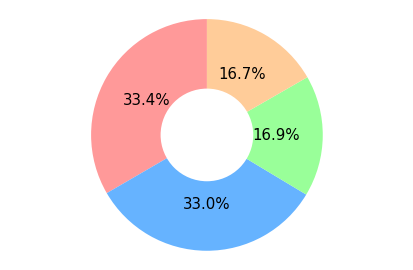

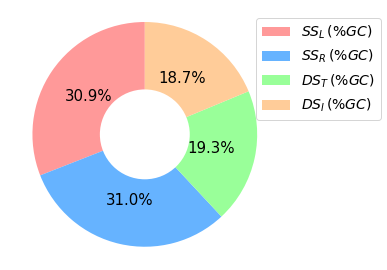

In [102]:
# Pie chart for Trial W
labels = [r'$SS_L\, (\%GC)$', '$SS_R\, (\%GC)$', '$DS_T\, (\%GC)$', '$DS_I\, (\%GC)$']
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots()
ax1.pie(support_t1.iloc[0].values, colors = colors, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig(path + '..//viz//pie_hoa_trialW.jpg', dpi = 250)

fig2, ax2 = plt.subplots()
ax2.pie(support_t1.iloc[1].values, colors = colors, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.legend(labels, loc = 'upper right', fontsize = 14, bbox_to_anchor=(1.4, 1.))
plt.tight_layout()
plt.savefig(path + '..//viz//pie_pwms_trialW.jpg', dpi = 250)
plt.show()

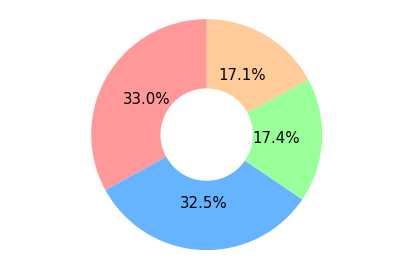

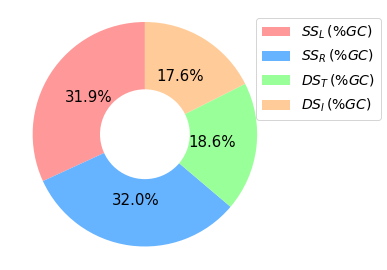

In [103]:
# Pie chart for Trial WT
labels = [r'$SS_L\, (\%GC)$', '$SS_R\, (\%GC)$', '$DS_T\, (\%GC)$', '$DS_I\, (\%GC)$']
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(support_t2.iloc[0].values, colors = colors, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig(path + '..//viz//pie_hoa_trialWT.jpg', dpi = 250)

fig2, ax2 = plt.subplots()
ax2.pie(support_t2.iloc[1].values, colors = colors, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle =  plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.legend(labels, loc = 'upper right', fontsize = 14, bbox_to_anchor=(1.4, 1.))
plt.tight_layout()
plt.savefig(path + '..//viz//pie_pwms_trialWT.jpg', dpi = 250)
plt.show()

### Correlations 

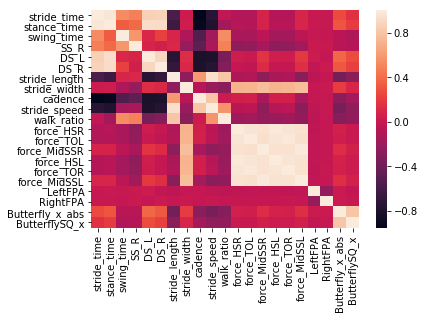

In [76]:
features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_L', 'DS_R', 'stride_length', 'stride_width',
       'cadence', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL']
stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
corr1 = regressN_df[regressN_df['TrialID']==2][stat_features].corr()
sns.heatmap(corr1)

#### Correlation of gait features in PwMS with EDSS scores

In [13]:
edss= pd.read_csv(path+'..//..//edss.csv')

#Keeping edss of only the 17 PwMS subjects we have the raw data for 
edss = edss[edss['PID'].isin(raw_df[raw_df['Label']==1]['PID'].unique())].reset_index().drop('index', axis =1)

features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'cadence', 'stride_length', 'stride_width',
    
            'LeftFPA', 'RightFPA', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL']
stat_features = features+['Butterfly_x_abs', 'ButterflySQ_x']

#Mean of the extracted gait features for PwMS in raw data - Trial W
raw_pwms_means = raw_df[raw_df['Label']==1][raw_df['TrialID']==1].groupby('PID').mean()[stat_features]
#sizeN data Trial W
sizeN_pwms_means = sizeN_df[sizeN_df['Label']==1][raw_df['TrialID']==1].groupby('PID').mean()[stat_features]
#regressN data Trial W
regressN_pwms_means = regressN_df[regressN_df['Label']==1][raw_df['TrialID']==1].groupby('PID').mean()[stat_features]

#Mean of the extracted gait features for PwMS in raw data - Trial WT
raw_pwms_means_t2 = raw_df[raw_df['Label']==1][raw_df['TrialID']==2].groupby('PID').mean()[stat_features]
#sizeN data Trial W
sizeN_pwms_means_t2 = sizeN_df[sizeN_df['Label']==1][raw_df['TrialID']==2].groupby('PID').mean()[stat_features]
#regressN data Trial W
regressN_pwms_means_t2 = regressN_df[regressN_df['Label']==1][raw_df['TrialID']==2].groupby('PID').mean()[stat_features]

edss.set_index('PID', inplace = True)

In [14]:
spearman_edss_raw, p_raw, spearman_edss_raw2, p_raw2 = [], [], [], []
spearman_edss_sizeN, p_sizeN, spearman_edss_sizeN2, p_sizeN2 = [], [], [], []
spearman_edss_regressN, p_regressN, spearman_edss_regressN2, p_regressN2 = [], [], [], []

for feat in stat_features:
    spearman_edss_raw.append(stats.spearmanr(raw_pwms_means[feat], edss.iloc[:, 0])[0])
    p_raw.append(stats.spearmanr(raw_pwms_means[feat], edss.iloc[:, 0])[1])
    spearman_edss_sizeN.append(stats.spearmanr(sizeN_pwms_means[feat], edss.iloc[:, 0])[0])
    p_sizeN.append(stats.spearmanr(sizeN_pwms_means[feat], edss.iloc[:, 0])[1])
    spearman_edss_regressN.append(stats.spearmanr(regressN_pwms_means[feat], edss.iloc[:, 0])[0])
    p_regressN.append(stats.spearmanr(regressN_pwms_means[feat], edss.iloc[:, 0])[1])

    spearman_edss_raw2.append(stats.spearmanr(raw_pwms_means_t2[feat], edss.iloc[:, 0])[0])
    p_raw2.append(stats.spearmanr(raw_pwms_means_t2[feat], edss.iloc[:, 0])[1])
    spearman_edss_sizeN2.append(stats.spearmanr(sizeN_pwms_means_t2[feat], edss.iloc[:, 0])[0])
    p_sizeN2.append(stats.spearmanr(sizeN_pwms_means_t2[feat], edss.iloc[:, 0])[1])
    spearman_edss_regressN2.append(stats.spearmanr(regressN_pwms_means_t2[feat], edss.iloc[:, 0])[0])
    p_regressN2.append(stats.spearmanr(regressN_pwms_means_t2[feat], edss.iloc[:, 0])[1])

#Trial W
A = pd.DataFrame(data = np.array([spearman_edss_raw, p_raw, spearman_edss_sizeN, p_sizeN, spearman_edss_regressN, 
                                  p_regressN]).T, index = stat_features, columns = ['raw', 'p_raw', 'sizeN', 'p_sizeN',
                                                                                    'regressN', 'p_regressN'])
A = A.round(decimals = 2)

#Trial WT
B = pd.DataFrame(data = np.array([spearman_edss_raw2, p_raw2, spearman_edss_sizeN2, p_sizeN2, spearman_edss_regressN2, 
                                  p_regressN2]).T, index = stat_features, columns = ['raw', 'p_raw', 'sizeN', 'p_sizeN',
                                                                                    'regressN', 'p_regressN'])
B = B.round(decimals = 2)

A.to_csv(path+'..//viz//corr_edss_trialw.csv')
B.to_csv(path+'..//viz//corr_edss_trialwt.csv')

In [26]:
# fig, axes = plt.subplots(2, 1, sharex=False, sharey = True, figsize=(13.8, 10.6))
# sns.despine(offset=0)

# #Trial W
# A=A.iloc[:, [0, 2, 4]] #Restricting only to correlation values and neglecting the p-values 
# sign = copy.deepcopy(A.T)
# sign[A.T<0]=-1
# sign[A.T>=0]=1

# ranked_A = A.T.abs().rank(method = 'first')-1
# ranked_A_new = copy.deepcopy(ranked_A)
# ranked_A_new.iloc[0] = [x for y, x in sorted(zip(np.where(ranked_A==0)[1], np.where(ranked_A==0)[0]))] 
# ranked_A_new.iloc[1] = [x for y, x in sorted(zip(np.where(ranked_A==1)[1], np.where(ranked_A==1)[0]))] 
# ranked_A_new.iloc[2] = [x for y, x in sorted(zip(np.where(ranked_A==2)[1], np.where(ranked_A==2)[0]))] 
# sorted_A = pd.DataFrame({x: A.T[x].iloc[ranked_A_new[x].values].values for x in A.T.columns.values})

# l1 = np.where(ranked_A==1)
# l1_sort = [(x, y) for y, x in sorted(zip(l1[1], l1[0]))] 
# for idx, x in enumerate(l1_sort):
#     ranked_A.iloc[x] = sorted_A.loc[0].values[idx] 
# l2 = np.where(ranked_A==2)
# l2_sort = [(x, y) for y, x in sorted(zip(l2[1], l2[0]))] 
# for idx, x in enumerate(l2_sort):
#     ranked_A.iloc[x] = sorted_A.loc[1].values[idx] 
# data = A.T - ranked_A
# data_stack = ranked_A

# data['force_HSR'] = [0.10, -0.41, -0.03]
# data_stack['force_HSR'] = [-0.03, -0.03, 0.00]
# data['force_HSL'] = [0.06, -0.39, -0.01]
# data_stack['force_HSL'] = [-0.01, -0.01, 0.00]

# data = data[sorted_A.iloc[2].sort_values().index]
# data_stack = data_stack[sorted_A.iloc[2].sort_values().index]

# names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
#        r'$DS_I$',  r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
#        r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
#        r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

# feature_display_names = {A.T.columns[i]: names[i] for i in range(len(names))}
# feature_display_names_sorted = [feature_display_names[x] for x in sorted_A.iloc[2].sort_values().index]
# cols = ['lightsalmon', '#66b3ff','#99ff99']

# for i in np.arange(0, 3):
#     axes[0].bar(np.arange(21), data.iloc[i], bottom=data_stack.iloc[i], color=cols[i])

# axes[0].set_xticks(np.arange(21))
# axes[0].legend(['Raw', 'Size-N', 'Regress-N'], loc = 'best')
# axes[0].axhline(linewidth=1, color='k')
# axes[0].set_xticklabels(feature_display_names_sorted)
# axes[0].set_title('Trial W')
# axes[0].set_ylim((-1, 1))

# #Trial WT
# B=B.iloc[:, [0, 2, 4]] #Restricting only to correlation values and neglecting the p-values
# sign = copy.deepcopy(B.T)
# sign[B.T<0]=-1
# sign[B.T>=0]=1

# # sorted_B = sign.values*pd.DataFrame({x: B.T[x].abs().sort_values().values for x in B.T.columns.values})
# ranked_B = B.T.abs().rank(method = 'first')-1
# ranked_B_new = copy.deepcopy(ranked_B)
# ranked_B_new.iloc[0] = [x for y, x in sorted(zip(np.where(ranked_B==0)[1], np.where(ranked_B==0)[0]))] 
# ranked_B_new.iloc[1] = [x for y, x in sorted(zip(np.where(ranked_B==1)[1], np.where(ranked_B==1)[0]))] 
# ranked_B_new.iloc[2] = [x for y, x in sorted(zip(np.where(ranked_B==2)[1], np.where(ranked_B==2)[0]))] 
# sorted_B = pd.DataFrame({x: B.T[x].iloc[ranked_B_new[x].values].values for x in B.T.columns.values})

# l1 = np.where(ranked_B==1)
# l1_sort = [(x, y) for y, x in sorted(zip(l1[1], l1[0]))] 
# for idx, x in enumerate(l1_sort):
#     ranked_B.iloc[x] = sorted_B.loc[0].values[idx] 
# l2 = np.where(ranked_B==2)
# l2_sort = [(x, y) for y, x in sorted(zip(l2[1], l2[0]))] 
# for idx, x in enumerate(l2_sort):
#     ranked_B.iloc[x] = sorted_B.loc[1].values[idx] 
# data = B.T - ranked_B
# data_stack = ranked_B

# data = data[sorted_B.iloc[2].sort_values().index]
# data_stack = data_stack[sorted_B.iloc[2].sort_values().index]

# data['force_HSR'] = [0.08, -0.21, -0.02]
# data_stack['force_HSR'] = [0.0, -0.02, 0.00]
# data['force_TOR'] = [0.05, -0.30, 0.05]
# data_stack['force_TOR'] = [0.00, 0.00, 0.05]
# data['force_HSL'] = [0.25, -0.15, -0.12]
# data_stack['force_HSL'] = [0.00, -0.12, 0.00]
# data['swing_time'] = [0.01, -0.07, 0.00]
# data_stack['swing_time'] = [0.00, 0.00, 0.00]
# data['force_TOL'] = [0.04, -0.09, 0.16]
# data_stack['force_TOL'] = [0.00, 0.00, 0.04]
# data['stride_width'] = [0.02, 0.23, -0.08]
# data_stack['stride_width'] = [0.00, 0.02, 0.00]

# names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
#        r'$DS_I$', r'$C$', r'$SL$', r'$SW$',  r'$\theta_L$', r'$\theta_R$', r'$SS$',
#        r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
#        r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

# feature_display_names = {B.T.columns[i]: names[i] for i in range(len(names))}
# feature_display_names_sorted = [feature_display_names[x] for x in sorted_B.iloc[2].sort_values().index]
# cols = ['lightsalmon', '#66b3ff','#99ff99']

# for i in np.arange(0, 3):
#     axes[1].bar(np.arange(21), data.iloc[i], bottom=data_stack.iloc[i], color=cols[i],)

# axes[1].set_xticks(np.arange(21))
# axes[1].set_xticklabels(feature_display_names_sorted)
# axes[1].axhline(linewidth=1, color='k')
# axes[1].set_ylim((-1, 1))
# axes[1].set_title('Trial WT')

# plt.savefig(path+'..//viz//corr_edss_trialw_and_wt.jpg', dpi = 250)
# plt.show()

### Side by side barplot for correlation with EDSS rather than a stackplot

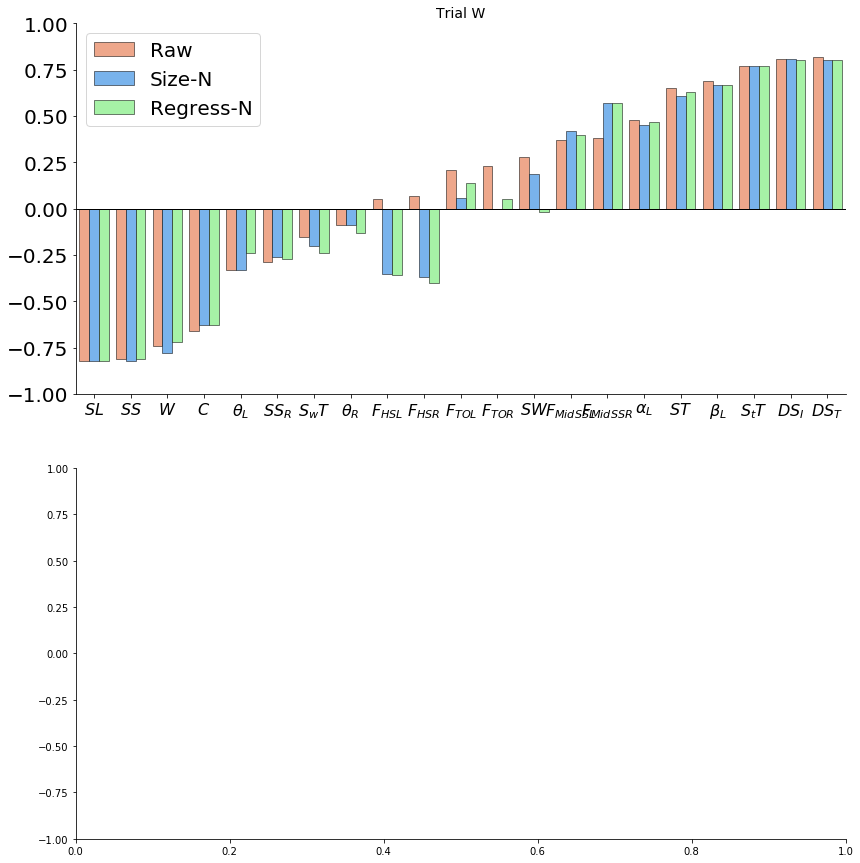

In [28]:
fig, axes = plt.subplots(2, 1, sharex=False, sharey = True, figsize=(13.8, 15))
axes[0].tick_params(labelsize=20)
sns.despine(offset=0)
names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
       r'$DS_I$',  r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

#Trial W
A=A.iloc[:, [0, 2, 4]] #Restricting only to correlation values and neglecting the p-values 
feature_display_names = {A.T.columns[i]: names[i] for i in range(len(names))}

sortedA = A.sort_values(by = 'raw')
barA = sortedA.reset_index().melt(id_vars=['index'], value_vars=['raw', 'sizeN', 'regressN'])
feature_display_names_sorted = [feature_display_names[x] for x in sortedA.index]



cols = ['lightsalmon', '#66b3ff','#99ff99']

sns.barplot(y = 'value', x = 'index', hue = 'variable', data = barA, palette= cols, linewidth = 0.5, \
                 edgecolor = 'k', hue_order = ['raw', 'sizeN', 'regressN'], ax= axes[0])

handles, _ = axes[0].get_legend_handles_labels()
axes[0].set_xticks(np.arange(21))
axes[0].legend(handles, ['Raw', 'Size-N','Regress-N'], loc = 'best', fontsize = 20)
axes[0].axhline(linewidth=1, color='k')
axes[0].set_xticklabels(feature_display_names_sorted, fontsize = 16)
axes[0].set_title('Trial W', fontsize = 14)
axes[0].set_xlabel('')
axes[0].set_ylim((-1, 1))
axes[0].set_ylabel('')

# #Trial WT
# B=B.iloc[:, [0, 2, 4]] #Restricting only to correlation values and neglecting the p-values
# feature_display_names = {B.T.columns[i]: names[i] for i in range(len(names))}

# sortedB = B.sort_values(by = 'raw')
# barB = sortedB.reset_index().melt(id_vars=['index'], value_vars=['raw', 'sizeN', 'regressN'])
# feature_display_names_sorted = [feature_display_names[x] for x in sortedB.index]

# names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
#        r'$DS_I$', r'$C$', r'$SL$', r'$SW$',  r'$\theta_L$', r'$\theta_R$', r'$SS$',
#        r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
#        r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']


# cols = ['lightsalmon', '#66b3ff','#99ff99']

# sns.barplot(y = 'value', x = 'index', hue = 'variable', data = barB, palette= cols, linewidth = 0.5, \
#                  edgecolor = 'k', hue_order = ['raw', 'sizeN', 'regressN'], ax = axes[1])

# axes[1].set_xticks(np.arange(21))
# axes[1].set_xticklabels(feature_display_names_sorted, fontsize = 11.5)
# handles, _ = axes[1].get_legend_handles_labels()
# axes[1].legend(handles,  ['Raw', 'Size-N','Regress-N'], loc = 'best')
# axes[1].axhline(linewidth=1, color='k')
# axes[1].set_ylabel('')
# axes[1].set_xlabel('')
# axes[1].set_ylim((-1, 1))
# axes[1].set_title('Trial WT', fontsize = 14)

plt.savefig(path+'..//viz//corr_edss_trialw_and_wt_sidebyside_Wonly.jpg', dpi = 550)
plt.show()

### Plotting regression lines for correlations with EDSS (along with r, p values) for revision of paper

In [109]:
#Trial W - raw data - PwMS features and EDSS to plot the regression line 
raw_pwms_means_dummy = copy.deepcopy(raw_pwms_means)
raw_pwms_means_dummy['EDSS'] = edss.iloc[:, 0]

#Trial W - sizeN data - PwMS features and EDSS to plot the regression line 
sizeN_pwms_means_dummy = copy.deepcopy(sizeN_pwms_means)
sizeN_pwms_means_dummy['EDSS'] = edss.iloc[:, 0]

#Trial W - regressN data - PwMS features and EDSS to plot the regression line 
regressN_pwms_means_dummy = copy.deepcopy(regressN_pwms_means)
regressN_pwms_means_dummy['EDSS'] = edss.iloc[:, 0]

#Trial WT - raw data - PwMS features and EDSS to plot the regression line 
raw_pwms_means_t2_dummy = copy.deepcopy(raw_pwms_means_t2)
raw_pwms_means_t2_dummy['EDSS'] = edss.iloc[:, 0]

#Trial WT - sizeN data - PwMS features and EDSS to plot the regression line 
sizeN_pwms_means_t2_dummy = copy.deepcopy(sizeN_pwms_means_t2)
sizeN_pwms_means_t2_dummy['EDSS'] = edss.iloc[:, 0]

#Trial WT - regressN data - PwMS features and EDSS to plot the regression line 
regressN_pwms_means_t2_dummy = copy.deepcopy(regressN_pwms_means_t2)
regressN_pwms_means_t2_dummy['EDSS'] = edss.iloc[:, 0]

feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right single support', 'Initial double support', 
                         'Terminal double support', 'Cadence', 'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed',
                           'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
                           'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']
feature_display_names_dict = dict(zip(A.index.values, feature_display_names))

### Trial W

In [16]:
A.head()

,raw,p_raw,sizeN,p_sizeN,regressN,p_regressN
stride_time,0.65,0.00,0.61,0.01,0.63,0.01
stance_time,0.77,0.00,0.77,0.00,0.77,0.00
swing_time,-0.15,0.55,-0.20,0.45,-0.24,0.34
SS_R,-0.29,0.26,-0.26,0.31,-0.27,0.29
DS_R,0.82,0.00,0.80,0.00,0.80,0.00


In [17]:
raw_pwms_means_dummy.head()

,stride_time,stance_time,swing_time,SS_R,DS_R,DS_L,cadence,stride_length,stride_width,LeftFPA,...,walk_ratio,force_HSR,force_TOL,force_MidSSR,force_HSL,force_TOR,force_MidSSL,Butterfly_x_abs,ButterflySQ_x,EDSS
PID,,,,,,,,,,,,,,,,,,,,,
300,1.465800,1.103400,0.362400,0.385150,0.365250,0.353000,82.540117,0.606108,0.177758,-0.236544,...,0.014762,585.566462,637.316947,613.446595,588.488066,638.347431,628.462859,0.019687,0.000634,6.0
301,1.254000,0.823038,0.430962,0.434346,0.192038,0.196654,96.369557,1.349064,0.215356,0.413022,...,0.027942,696.616278,785.630126,660.886900,699.296299,777.234096,650.611212,0.016452,0.000480,1.0
302,1.094491,0.717298,0.377193,0.389825,0.165895,0.161579,110.804797,1.210162,0.150678,0.171565,...,0.021928,666.897564,633.566850,572.769347,687.996692,636.306086,584.153164,0.010648,0.000155,1.5
303,1.019406,0.661094,0.358313,0.358000,0.151781,0.151312,118.432496,1.410748,0.108687,-0.644249,...,0.023762,656.698526,772.790031,492.320438,648.833228,768.133186,514.323760,0.011470,0.000310,3.5
304,1.233273,0.836318,0.396955,0.431591,0.206136,0.198591,97.689911,1.159084,0.105945,0.377765,...,0.023640,619.058291,619.657314,588.606899,628.601537,642.277688,571.738121,0.010913,0.000179,4.0


In [18]:
feature_display_names

['Stride time',
 'Stance time',
 'Swing time',
 'Right SS',
 'Initial DS',
 'Terminal DS',
 'Cadence',
 'Stride length',
 'Stride width',
 'Left FPA',
 'Right FPA',
 'Stride speed',
 'Walk ratio',
 'Force-HSR',
 'Force-TOL',
 'Force-MidSSR',
 'Force-HSL',
 'Force-TOR',
 'Force-MidSSL',
 'Lateral shift',
 'Lateral deviation']

In [21]:
raw_pwms_means_dummy.head()

,stride_time,stance_time,swing_time,SS_R,DS_R,DS_L,cadence,stride_length,stride_width,LeftFPA,...,force_TOL,force_MidSSR,force_HSL,force_TOR,force_MidSSL,Butterfly_x_abs,ButterflySQ_x,EDSS,EDSS_rank,stride_time_rank
PID,,,,,,,,,,,,,,,,,,,,,
300,1.465800,1.103400,0.362400,0.385150,0.365250,0.353000,82.540117,0.606108,0.177758,-0.236544,...,637.316947,613.446595,588.488066,638.347431,628.462859,0.019687,0.000634,6.0,14.5,13.0
301,1.254000,0.823038,0.430962,0.434346,0.192038,0.196654,96.369557,1.349064,0.215356,0.413022,...,785.630126,660.886900,699.296299,777.234096,650.611212,0.016452,0.000480,1.0,1.0,10.0
302,1.094491,0.717298,0.377193,0.389825,0.165895,0.161579,110.804797,1.210162,0.150678,0.171565,...,633.566850,572.769347,687.996692,636.306086,584.153164,0.010648,0.000155,1.5,2.0,5.0
303,1.019406,0.661094,0.358313,0.358000,0.151781,0.151312,118.432496,1.410748,0.108687,-0.644249,...,772.790031,492.320438,648.833228,768.133186,514.323760,0.011470,0.000310,3.5,6.5,3.0
304,1.233273,0.836318,0.396955,0.431591,0.206136,0.198591,97.689911,1.159084,0.105945,0.377765,...,619.657314,588.606899,628.601537,642.277688,571.738121,0.010913,0.000179,4.0,8.5,9.0


In [ ]:
#Trial W - raw data 
# Linear regression with one independent variable
raw_pwms_means_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(raw_pwms_means_dummy["EDSS"])
for i, feat in enumerate(stat_features[6:13]):
    raw_pwms_means_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(raw_pwms_means_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=raw_pwms_means_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(A.loc[feat]['raw']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(A.loc[feat]['p_raw']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialW//raw//'+feat+'_raw_trialW.jpg', dpi = 550)
    plt.show()

In [ ]:
#Trial W - sizeN data 
# Linear regression with one independent variable
sizeN_pwms_means_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(sizeN_pwms_means_dummy["EDSS"])
for i, feat in enumerate(stat_features[9:13]):
    sizeN_pwms_means_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(sizeN_pwms_means_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=sizeN_pwms_means_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(A.loc[feat]['sizeN']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(A.loc[feat]['p_sizeN']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialW//sizeN//'+feat+'_sizeN_trialW.jpg', dpi = 550)
    plt.show()

In [ ]:
#Trial W - regressN data 
# Linear regression with one independent variable
regressN_pwms_means_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(regressN_pwms_means_dummy["EDSS"])
for i, feat in enumerate(stat_features[6:8]):
    regressN_pwms_means_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(regressN_pwms_means_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=regressN_pwms_means_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(A.loc[feat]['regressN']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(A.loc[feat]['p_regressN']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialW//regressN//'+feat+'_regressN_trialW.jpg', dpi = 550)
    plt.show()

### Trial WT

In [122]:
B.head()

,raw,p_raw,sizeN,p_sizeN,regressN,p_regressN
stride_time,0.77,0.00,0.78,0.00,0.79,0.00
stance_time,0.82,0.00,0.82,0.00,0.82,0.00
swing_time,0.01,0.96,-0.06,0.83,0.01,0.96
SS_R,-0.12,0.65,-0.13,0.61,-0.12,0.65
DS_R,0.81,0.00,0.82,0.00,0.82,0.00


In [ ]:
#Trial WT - raw data 
# Linear regression with one independent variable
raw_pwms_means_t2_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(raw_pwms_means_t2_dummy["EDSS"])
for i, feat in enumerate(stat_features[6:13]):
    raw_pwms_means_t2_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(raw_pwms_means_t2_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=raw_pwms_means_t2_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(B.loc[feat]['raw']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(B.loc[feat]['p_raw']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialWT//raw//'+feat+'_raw_trialWT.jpg', dpi = 550)
    plt.show()

In [ ]:
#Trial WT - sizeN data 
# Linear regression with one independent variable
sizeN_pwms_means_t2_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(sizeN_pwms_means_t2_dummy["EDSS"])
for i, feat in enumerate(stat_features):
    sizeN_pwms_means_t2_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(sizeN_pwms_means_t2_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=sizeN_pwms_means_t2_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(B.loc[feat]['sizeN']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(B.loc[feat]['p_sizeN']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialWT//sizeN//'+feat+'_sizeN_trialWT.jpg', dpi = 550)
    plt.show()

In [ ]:
#Trial WT - regressN data 
# Linear regression with one independent variable
regressN_pwms_means_t2_dummy["EDSS_rank"] = scipy.stats.stats.rankdata(regressN_pwms_means_t2_dummy["EDSS"])
for i, feat in enumerate(stat_features):
    regressN_pwms_means_t2_dummy[feat+"_rank"] = scipy.stats.stats.rankdata(regressN_pwms_means_t2_dummy[feat])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feat+"_rank", y="EDSS_rank", data=regressN_pwms_means_t2_dummy, scatter = True, \
               scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.tick_params(labelsize=15)
    plt.text(2, 4, 'r = '+str(B.loc[feat]['regressN']), fontsize = 15)
    plt.text(2, 3, 'p = '+str(B.loc[feat]['p_regressN']), fontsize = 15)
    plt.legend(['Regression line', 'Observed data'], fontsize = 14, loc = 'best')
    plt.xlabel(feature_display_names_dict[feat]+' rank', fontsize = 16)
    plt.ylabel('EDSS rank', fontsize = 16)
    plt.savefig(path+'..//edss_correlation//trialWT//regressN//'+feat+'_regressN_trialWT.jpg', dpi = 550)
    plt.show()

In [147]:
B.head()

,raw,p_raw,sizeN,p_sizeN,regressN,p_regressN
stride_time,0.77,0.00,0.78,0.00,0.79,0.00
stance_time,0.82,0.00,0.82,0.00,0.82,0.00
swing_time,0.01,0.96,-0.06,0.83,0.01,0.96
SS_R,-0.12,0.65,-0.13,0.61,-0.12,0.65
DS_R,0.81,0.00,0.82,0.00,0.82,0.00


#### Correlation of gait features with physical characteristics of the subjects 

In [16]:
features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'cadence', 'stride_length', 'stride_width',
     'LeftFPA', 'RightFPA', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL']
stat_features = features+['Butterfly_x_abs', 'ButterflySQ_x']

In [17]:
#Mean of the extracted gait features for PwMS in raw data - Trial W
raw_means = raw_df[raw_df['TrialID']==1].groupby('PID').mean()[stat_features]
#sizeN data Trial W
sizeN_means = sizeN_df[sizeN_df['TrialID']==1].groupby('PID').mean()[stat_features]
#regressN data Trial W
regressN_means = regressN_df[regressN_df['TrialID']==1].groupby('PID').mean()[stat_features]

#Mean of the extracted gait features for PwMS in raw data - Trial WT
raw_means_t2 = raw_df[raw_df['TrialID']==2].groupby('PID').mean()[stat_features]
#sizeN data Trial W
sizeN_means_t2 = sizeN_df[sizeN_df['TrialID']==2].groupby('PID').mean()[stat_features]
#regressN data Trial W
regressN_means_t2 = regressN_df[regressN_df['TrialID']==2].groupby('PID').mean()[stat_features]

#Demographic features to find the correlation with
demo_features = ['weight (kg)', 'age (yrs)', 'height (m)', 'subject ID']
demo_corr = demographies[demo_features].set_index('subject ID')
demo_corr.sort_values(by = 'subject ID', inplace=True)

demo_gender = demographies[['gender (1-female, 2-male)', 'subject ID']].set_index('subject ID')
demo_gender.sort_values(by = 'subject ID', inplace=True)

In [18]:
#Trial W and WT (weight age height)
spearman_raw, p_raw, spearman_raw2, p_raw2 = [], [], [], []
spearman_sizeN, p_sizeN, spearman_sizeN2, p_sizeN2 = [], [], [], []
spearman_regressN, p_regressN, spearman_regressN2, p_regressN2 = [], [], [], []

for feat in stat_features:
    #Trial W
    x1 = stats.spearmanr(demo_corr.values, raw_means[feat].values)[0][-1, :-1] #Weight, Age, Height 
    #Point Biserial correlation coefficient is used to examine correlation between a categorical and a numerical variable 
    #For gender since it is a categorical variable 
    spearman_raw.append(np.append(x1, stats.pointbiserialr(demo_gender.values.T[0], raw_means[feat].values)[0])) #For gender 
    y1 = stats.spearmanr(demo_corr.values, raw_means[feat].values)[1][-1, :-1]
    p_raw.append(np.append(y1, stats.pointbiserialr(demo_gender.values.T[0], raw_means[feat].values)[1])) #For gender 
    x2 = stats.spearmanr(demo_corr.values, sizeN_means[feat].values)[0][-1, :-1]
    spearman_sizeN.append(np.append(x2, stats.pointbiserialr(demo_gender.values.T[0], sizeN_means[feat].values)[0])) #For gender 
    y2 = stats.spearmanr(demo_corr.values, sizeN_means[feat].values)[1][-1, :-1]
    p_sizeN.append(np.append(y2, stats.pointbiserialr(demo_gender.values.T[0], sizeN_means[feat].values)[1])) #For gender 
    x3 = stats.spearmanr(demo_corr.values, regressN_means[feat].values)[0][-1, :-1]
    spearman_regressN.append(np.append(x3, stats.pointbiserialr(demo_gender.values.T[0], regressN_means[feat].values)[0])) #For gender 
    y3 = stats.spearmanr(demo_corr.values, regressN_means[feat].values)[1][-1, :-1]
    p_regressN.append(np.append(y3, stats.pointbiserialr(demo_gender.values.T[0], regressN_means[feat].values)[1])) #For gender 
        
    #Trial WT
    x4 = stats.spearmanr(demo_corr.values, raw_means_t2[feat].values)[0][-1, :-1] #Weight, Age, Height 
    #Point Biserial correlation coefficient is used to examine correlation between a categorical and a numerical variable 
    #For gender since it is a categorical variable 
    spearman_raw2.append(np.append(x4, stats.pointbiserialr(demo_gender.values.T[0], raw_means_t2[feat].values)[0])) #For gender 
    y4 = stats.spearmanr(demo_corr.values, raw_means_t2[feat].values)[1][-1, :-1]
    p_raw2.append(np.append(y4, stats.pointbiserialr(demo_gender.values.T[0], raw_means_t2[feat].values)[1])) #For gender 
    x5 = stats.spearmanr(demo_corr.values, sizeN_means_t2[feat].values)[0][-1, :-1]
    spearman_sizeN2.append(np.append(x5, stats.pointbiserialr(demo_gender.values.T[0], sizeN_means_t2[feat].values)[0])) #For gender 
    y5 = stats.spearmanr(demo_corr.values, sizeN_means_t2[feat].values)[1][-1, :-1]
    p_sizeN2.append(np.append(y5, stats.pointbiserialr(demo_gender.values.T[0], sizeN_means_t2[feat].values)[1])) #For gender 
    x6 = stats.spearmanr(demo_corr.values, regressN_means_t2[feat].values)[0][-1, :-1]
    spearman_regressN2.append(np.append(x6, stats.pointbiserialr(demo_gender.values.T[0], regressN_means_t2[feat].values)[0])) #For gender 
    y6 = stats.spearmanr(demo_corr.values, regressN_means_t2[feat].values)[1][-1, :-1]
    p_regressN2.append(np.append(y6, stats.pointbiserialr(demo_gender.values.T[0], regressN_means_t2[feat].values)[1])) #For gender 
        
#Trial W
A = pd.DataFrame(data = np.concatenate((spearman_raw, p_raw, spearman_sizeN, p_sizeN, spearman_regressN, 
                                  p_regressN), axis =1), index = stat_features)
A.columns = ['raw_weight', 'raw_age', 'raw_height', 'raw_gender', 'p_raw_weight', 'p_raw_age', 'p_raw_height', 'p_raw_gender',
             'sizeN_weight', 'sizeN_age', 'sizeN_height', 'sizeN_gender', 'p_sizeN_weight', 'p_sizeN_age', 'p_sizeN_height', 
             'p_sizeN_gender', 'regressN_weight', 'regressN_age', 'regressN_height', 'regressN_gender',
             'p_regressN_weight', 'p_regressN_age', 'p_regressN_height', 'p_regressN_gender']
A = A.round(decimals = 2)

#Trial WT
B = pd.DataFrame(data = np.concatenate((spearman_raw2, p_raw2, spearman_sizeN2, p_sizeN2, spearman_regressN2, 
                                  p_regressN2), axis =1), index = stat_features)
B.columns = ['raw_weight', 'raw_age', 'raw_height', 'raw_gender', 'p_raw_weight', 'p_raw_age', 'p_raw_height', 'p_raw_gender',
             'sizeN_weight', 'sizeN_age', 'sizeN_height', 'sizeN_gender', 'p_sizeN_weight', 'p_sizeN_age', 'p_sizeN_height', 
             'p_sizeN_gender', 'regressN_weight', 'regressN_age', 'regressN_height', 'regressN_gender',
             'p_regressN_weight', 'p_regressN_age', 'p_regressN_height', 'p_regressN_gender']
B = B.round(decimals = 2)


A.to_csv(path+'..//viz//corr_physical_trialw.csv')
B.to_csv(path+'..//viz//corr_physical_trialwt.csv')

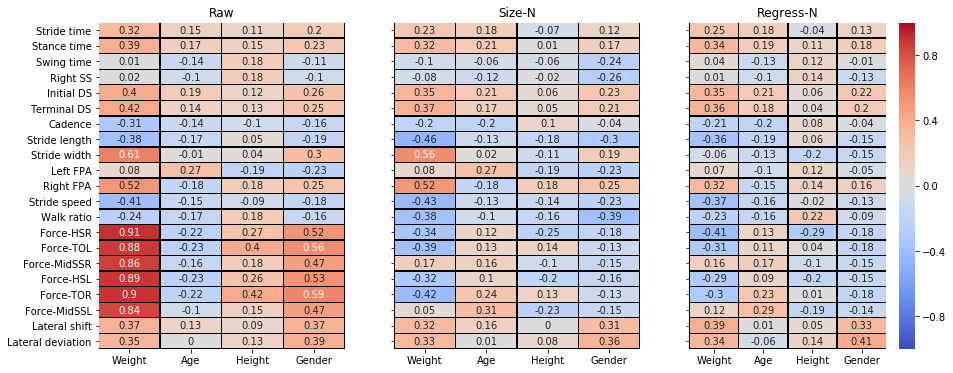

In [16]:
feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 
                         'Terminal DS', 'Cadence', 'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed',
                           'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
                           'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']

#Trial W heatmaps 
fig, axes = plt.subplots(1, 3, sharex=True, sharey = True, figsize=(15, 6))
xticklabels= ['Weight', 'Age', 'Height', 'Gender']
sns.heatmap(A.iloc[:, 0:4], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[0], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k", cbar = False)
axes[0].set_title('Raw')
sns.heatmap(A.iloc[:, 8:12], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[1], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k", cbar = False)
axes[1].set_title('Size-N')
sns.heatmap(A.iloc[:, 16:20], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[2], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k")
axes[2].set_title('Regress-N')
plt.savefig(path + '..//viz//corr_physical_trialW.jpg', dpi = 250)
plt.show()

### Plotting raw, sizeN and regressN correlations of F_TOL, F_TOR, SW, Right FPA with weight; F_TOL, F_TOR with height and F_HSL, F_HSR with gender for trial W

In [58]:
data = [[r'$F_{TOL}$', '1', 'raw', 0.88], [r'$F_{TOL}$', '1', 'sizeN', 0.39], [r'$F_{TOL}$', '1', 'regressN', 0.31],
       [r'$F_{TOR}$', '2', 'raw', 0.9], [r'$F_{TOR}$', '2', 'sizeN', 0.42], [r'$F_{TOR}$', '2', 'regressN', 0.3],
       [r'$SW$', '3', 'raw', 0.61], [r'$SW$', '3', 'sizeN', 0.56], [r'$SW$', '3', 'regressN', 0.06],
        [r'$\theta_R$', '4', 'raw', 0.52], [r'$\theta_R$', '4', 'sizeN', 0.52], [r'$\theta_R$', '4', 'regressN', 0.32],
       [r'$F_{TOL}$', '5', 'raw', 0.4], [r'$F_{TOL}$', '5', 'sizeN', 0.14], [r'$F_{TOL}$', '5', 'regressN', 0.04],
       [r'$F_{TOR}$', '6', 'raw', 0.42], [r'$F_{TOR}$', '6', 'sizeN', 0.13], [r'$F_{TOR}$', '6', 'regressN', 0.01],
       [r'$F_{HSL}$', '7', 'raw', 0.53], [r'$F_{HSL}$', '7', 'sizeN', 0.16], [r'$F_{HSL}$', '7', 'regressN', 0.15],
       [r'$F_{HSR}$', '8', 'raw', 0.52], [r'$F_{HSR}$', '8', 'sizeN', 0.18], [r'$F_{HSR}$', '8', 'regressN', 0.18]]
corr_physical = pd.DataFrame(data, columns = ['index', 'index2', 'variable', 'value'])

xticks = [r'$F_{TOL}$-weight', r'$F_{TOR}$-weight', r'$SW$-weight', r'$\theta_R$-weight', r'$F_{TOL}$-height', r'$F_{TOR}$-height', r'$F_{HSL}$-gender', r'$F_{HSR}$-gender']

In [ ]:
corr_physical

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=False, sharey = True, figsize=(13.8, 12))
axes[0].tick_params(labelsize=20)
sns.despine(offset=0)
cols = ['lightsalmon', '#66b3ff','#99ff99']

sns.barplot(y = 'value', x = 'index2', hue = 'variable', data = corr_physical, palette= cols, linewidth = 0.5, \
                 edgecolor = 'k', hue_order = ['raw', 'sizeN', 'regressN'], ax= axes[0])

handles, _ = axes[0].get_legend_handles_labels()
axes[0].set_xticks(np.arange(8))
axes[0].legend(handles, ['Raw', 'Size-N','Regress-N'], loc = 'best', fontsize = 20)
axes[0].axhline(linewidth=1, color='k')
axes[0].set_xticklabels(xticks, fontsize = 15.5)
# axes[0].set_title('Trial W', fontsize = 14)
axes[0].set_xlabel('')
axes[0].set_ylim((0, 1))
axes[0].set_ylabel('')
plt.savefig(path+'..//viz//corr_physical_features_revision_paper.jpg', dpi = 550)
plt.show()

In [17]:
print ((np.array(p_raw)<=0.05).sum(axis =0))
print ((np.array(p_sizeN)<=0.05).sum(axis =0))
print ((np.array(p_regressN)<=0.05).sum(axis =0))

#Basic Stats
print (np.min(spearman_raw), np.max(spearman_raw), np.mean(np.abs(spearman_raw)))
print (np.min(spearman_sizeN), np.max(spearman_sizeN), np.mean(np.abs(spearman_sizeN)))
print (np.min(spearman_regressN), np.max(spearman_regressN), np.mean(np.abs(spearman_regressN)))

#Low Moderate and High Correlations 
print ((np.abs(spearman_raw)>=0.7).sum(), ((np.abs(spearman_raw)>=0.5) & (np.abs(spearman_raw)<0.7)).sum(), 
       (np.abs(spearman_raw)<0.5).sum())

print ((np.abs(spearman_sizeN)>=0.7).sum(), ((np.abs(spearman_sizeN)>=0.5) & (np.abs(spearman_sizeN)<0.7)).sum(), 
       (np.abs(spearman_sizeN)<0.5).sum())

print ((np.abs(spearman_regressN)>=0.7).sum(), ((np.abs(spearman_regressN)>=0.5) & (np.abs(spearman_regressN)<0.7)).sum(), 
       (np.abs(spearman_regressN)<0.5).sum())

[15  0  2  8]
[10  0  0  2]
[8 0 0 2]
-0.4122426150542898 0.9117523552118152 0.2798592747703783
-0.45818742570254223 0.5577812073211627 0.19656563612145514
-0.4102815560632057 0.409666740584743 0.16905607386657195
6 6 72
0 2 82
0 0 84


In [18]:


(84-(np.abs(spearman_regressN)<0.3).sum())/84*100

15.476190476190476

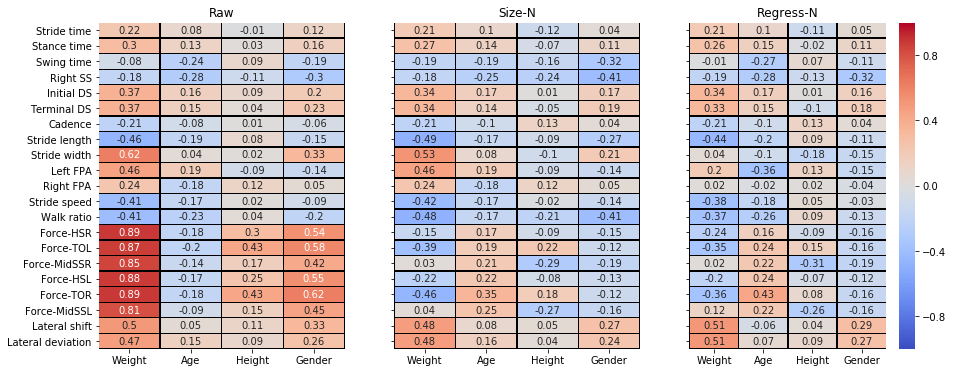

In [19]:
#Trial WT heatmaps 
fig, axes = plt.subplots(1, 3, sharex=True, sharey = True, figsize=(15, 6))
xticklabels= ['Weight', 'Age', 'Height', 'Gender']
sns.heatmap(B.iloc[:, 0:4], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[0], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k", cbar = False)
axes[0].set_title('Raw')
sns.heatmap(B.iloc[:, 8:12], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[1], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k", cbar = False)
axes[1].set_title('Size-N')
sns.heatmap(B.iloc[:, 16:20], vmin=-1, vmax=1, center = 0, cmap="coolwarm", ax = axes[2], annot=True, xticklabels=xticklabels, 
           yticklabels=feature_display_names, linewidths=0.4, linecolor="k")
axes[2].set_title('Regress-N')
plt.savefig(path + '..//viz//corr_physical_trialWT.jpg', dpi = 250)
plt.show()

In [20]:
print ((np.array(p_raw2)<=0.05).sum(axis =0))
print ((np.array(p_sizeN2)<=0.05).sum(axis =0))
print ((np.array(p_regressN2)<=0.05).sum(axis =0))

print (np.min(spearman_raw2), np.max(spearman_raw2), np.mean(np.abs(spearman_raw2)))
print (np.min(spearman_sizeN2), np.max(spearman_sizeN2), np.mean(np.abs(spearman_sizeN2)))
print (np.min(spearman_regressN2), np.max(spearman_regressN2), np.mean(np.abs(spearman_regressN2)))

#Low Moderate and High Correlations 
print ((np.abs(spearman_raw2)>=0.7).sum(), ((np.abs(spearman_raw2)>=0.5) & (np.abs(spearman_raw2)<0.7)).sum(), 
       (np.abs(spearman_raw2)<0.5).sum())

print ((np.abs(spearman_sizeN2)>=0.7).sum(), ((np.abs(spearman_sizeN2)>=0.5) & (np.abs(spearman_sizeN2)<0.7)).sum(), 
       (np.abs(spearman_sizeN2)<0.5).sum())

print ((np.abs(spearman_regressN2)>=0.7).sum(), ((np.abs(spearman_regressN2)>=0.5) & (np.abs(spearman_regressN2)<0.7)).sum(), 
       (np.abs(spearman_regressN2)<0.5).sum())

[15  0  2  6]
[11  1  0  2]
[8 2 0 0]
-0.45832750134476247 0.8903207819521121 0.26707783969211035
-0.49264603368873155 0.5346687263548162 0.2004529114340223
-0.4433394076271924 0.5115562453884696 0.17394251148494297
6 6 72
0 1 83
0 2 82


In [32]:
(84-(np.abs(spearman_regressN2)<0.3).sum())/84*100

15.476190476190476

#### Correlation among the physical characteristics of the subjects (to be used as independent variables for linear regression)

In [38]:
demo_features = ['weight (kg)', 'age (yrs)', 'height (m)']
print (demographies[demo_features].corr('spearman'))
print (stats.spearmanr(demographies[demo_features]))
demographies[demo_features].corr('spearman')

             weight (kg)  age (yrs)  height (m)
weight (kg)     1.000000  -0.279991     0.39777
age (yrs)      -0.279991   1.000000    -0.22967
height (m)      0.397770  -0.229670     1.00000
SpearmanrResult(correlation=array([[ 1.        , -0.27999077,  0.39776987],
       [-0.27999077,  1.        , -0.22967049],
       [ 0.39776987, -0.22967049,  1.        ]]), pvalue=array([[0.        , 0.10330017, 0.01796438],
       [0.10330017, 0.        , 0.18443408],
       [0.01796438, 0.18443408, 0.        ]]))


,weight (kg),age (yrs),height (m)
weight (kg),1.000000,-0.279991,0.39777
age (yrs),-0.279991,1.000000,-0.22967
height (m),0.397770,-0.229670,1.00000


In [39]:
#Point Biserial correlation coefficient is used to examine correlation between a categorical and a numerical variable 
#For gender since it is a categorical variable 
corr_with_gender = []
for feat in demo_features:
    corr_with_gender.append(stats.pointbiserialr(demographies['gender (1-female, 2-male)'], demographies[feat]))
print (corr_with_gender)

[PointbiserialrResult(correlation=0.5789394366082085, pvalue=0.0002688519738007653), PointbiserialrResult(correlation=-0.16652321813810114, pvalue=0.3390297379716988), PointbiserialrResult(correlation=0.7207878718380009, pvalue=1.0427142000131945e-06)]


### Dispersion 

                    raw   sizeN  regressN  raw_sizeN  raw_regressN  \
stride_time       18.44   18.32     18.46       0.12         -0.02   
stance_time       24.54   24.44     23.57       0.10          0.97   
swing_time        16.26   16.26     16.22       0.00          0.04   
SS_R              16.98   17.04     16.96      -0.06          0.02   
DS_L              44.21   44.23     41.72      -0.02          2.49   
DS_R              45.22   45.02     44.79       0.20          0.43   
stride_length     28.29   28.59     27.31      -0.30          0.98   
stride_width      36.45   35.98     34.14       0.47          2.31   
cadence           15.32   15.15     15.29       0.17          0.03   
stride_speed      37.00   37.23     34.72      -0.23          2.28   
walk_ratio        24.75   24.89     24.77      -0.14         -0.02   
force_HSR         24.20   33.06     22.61      -8.86          1.59   
force_TOL         24.25   35.97     30.78     -11.72         -6.53   
force_MidSSR      29

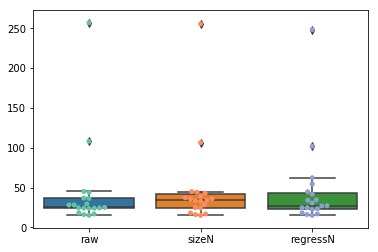

In [11]:
stat_features = features+['Butterfly_x_abs', 'ButterflySQ_x']
raw_df_grouped = raw_df[raw_df['TrialID']==1].abs()#.groupby('PID').median()
sizeN_df_grouped = sizeN_df[sizeN_df['TrialID']==1].abs()#.groupby('PID').median()
regressN_df_grouped = regressN_df[regressN_df['TrialID']==1].abs()#.groupby('PID').median()

#Coefficient of variation 
a = scipy.stats.variation(raw_df_grouped[stat_features], axis =0)*100
b = scipy.stats.variation(sizeN_df_grouped[stat_features], axis =0)*100
c = scipy.stats.variation(regressN_df_grouped[stat_features], axis =0)*100

#Average Deviation from mean 
# a = (raw_df_grouped[stat_features]-raw_df_grouped[stat_features].mean()).abs().mean()
# b = (sizeN_df_grouped[stat_features]-sizeN_df_grouped[stat_features].mean()).abs().mean()
# c = (regressN_df_grouped[stat_features]-regressN_df_grouped[stat_features].mean()).abs().mean()

#Range of the data 
# a = raw_df_grouped[stat_features].max()-raw_df_grouped[stat_features].min()
# b = sizeN_df_grouped[stat_features].max()-sizeN_df_grouped[stat_features].min()
# c = regressN_df_grouped[stat_features].max()-regressN_df_grouped[stat_features].min()

x = pd.DataFrame(data = np.array([a, b, c]).T, index = stat_features, columns = ['raw', 'sizeN', 'regressN']).round(decimals=2)
x['raw_sizeN'] = x['raw']-x['sizeN']
x['raw_regressN'] = x['raw']-x['regressN']
x['sizeN_regressN'] = x['sizeN']-x['regressN']
sns.boxplot(data=x[['raw', 'sizeN', 'regressN']])
sns.swarmplot(data=x[['raw', 'sizeN', 'regressN']], dodge = True, palette="Set2")

print (x)

### Extra exploration

In [ ]:
raw_df.corr()[raw_df.corr()>0.8]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

X, y = regressN_df[['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x', 
       'DS_R', 'SS_R', 'DS_L', 'SS_L', 'force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL',
       'stride_time', 'swing_time', 'stance_time', 'stride_length',
       'stride_width', 'stride_speed', 'cadence', 'walk_ratio']], regressN_df['Label']
normalized_X = preprocessing.scale(X)
clf = RandomForestClassifier()
k = 10
kf = KFold(n_splits = k, shuffle = True)
pipeline = make_pipeline(clf)
cv_result = cross_val_score(pipeline, normalized_X, y, cv = kf, scoring = 'roc_auc')
cv_result.mean()